In [1]:
import awkward
import xgboost
import numpy as np
import os
import json
import awkward as ak
import coffea.util as util
#%pip install sklearn
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

import hist

In [2]:
#%pip install tensorflow


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2024-04-12 15:11:30.294138: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 15:11:30.511358: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 15:11:30.988013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:11:34.324094: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1


In [3]:
from operator import itemgetter

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def choose_jet(jets_variable, n, fill_value):
    """
    this helper function is used to create flat jets from a jagged collection,
    parameters:
    * jet_variable: (ak array) selected variable from the jet collection
    * n: (int) nth jet to be selected
    * fill_value: (float) value with wich to fill the padded none.
    """
    leading_jets_variable = jets_variable[
        ak.local_index(jets_variable) == n
    ]
    leading_jets_variable = ak.pad_none(
        leading_jets_variable, 1
    )
    leading_jets_variable = ak.flatten(
        ak.fill_none(leading_jets_variable, fill_value)
    )
    return leading_jets_variable

In [4]:
%ll inputs/merged/

total 12
drwxr-xr-x 15 bevila_t 15 Mar 22 18:04 bH_5FS_FXFX_M125_2017/
drwxr-xr-x 15 bevila_t 15 Mar 22 18:07 cH_4FS_FXFX_M125_2017/
drwxr-xr-x 15 bevila_t 15 Mar 22 18:08 ggh_M125_2017/
drwxr-xr-x 15 bevila_t 15 Mar 22 18:09 tth_M125_2017/
drwxr-xr-x 15 bevila_t 15 Mar 22 18:12 vbf_M125_2017/
drwxr-xr-x 15 bevila_t 15 Mar 22 18:14 vh_M125_2017/


In [5]:
proc_dict = {
    "ggh_M125_2017": {
        #"file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/ggh_M125_2017/nominal/NOTAG_merged.parquet",
        "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/ggh_M125_2017/NOTAG_merged.parquet",
        "type": "background",
        "label": 0.,
        "proc_id": 1,
    },
    "tth_M125_2017": {
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/tth_M125_2017/nominal/NOTAG_merged.parquet",
        "type": "background",
        "coffea": "input/signals.coffea",
        "label": 0.,
        "proc_id": 2,
    },
    "vbf_M125_2017": {
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/vbf_M125_2017/nominal/NOTAG_merged.parquet",
        "type": "background",
        "coffea": "input/signals.coffea",
        "label": 0.,
        "proc_id": 3,
    },
    "vh_M125_2017": {
        "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/vh_M125_2017/nominal/NOTAG_merged.parquet",
        "type": "background",
        "coffea": "input/signals.coffea",
        "label": 0.,
        "proc_id": 4,
    },
    "cH_4FS_FXFX_M125_2017": {
        "file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/master/SYST/higgs-dna-tiziano-bevilacqua/output/output_test_dlenSig/merged/cH_4FS_FXFX_M125_2017/NOTAG_merged.parquet",
        "type": "signal",
        "label": 1.,
        "proc_id": 5,
    },
    # "bH_5FS_FXFX_M125_2017": {
    #     "file": "/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/bH_5FS_FXFX_M125_2017/nominal/NOTAG_merged.parquet",
    #     "type": "background",
    #     "label": 0.,
    #     "proc_id": 6,
    # }
}

In [6]:
e = ak.from_parquet("/work/bevila_t/HpC_Analysis/cHvsggH_BDT_training/inputs/merged/cH_4FS_FXFX_M125_2017/nominal/NOTAG_merged.parquet")
e.fields

['weight_central',
 'centralObjectWeight',
 'bdt_score',
 'dZ',
 'CMS_hgg_mass',
 'event',
 'pt',
 'eta',
 'phi',
 'LeadPhoton_pt_mgg',
 'LeadPhoton_eta',
 'LeadPhoton_ScEta',
 'LeadPhoton_phi',
 'LeadPhoton_mvaID',
 'SubleadPhoton_pt_mgg',
 'SubleadPhoton_eta',
 'SubleadPhoton_ScEta',
 'SubleadPhoton_phi',
 'SubleadPhoton_mvaID',
 'LeadPhoton_pt',
 'SubleadPhoton_pt',
 'LeadPhoton_energy',
 'LeadPhoton_energyErr',
 'LeadPhoton_energyRaw',
 'SubleadPhoton_energy',
 'SubleadPhoton_energyErr',
 'SubleadPhoton_energyRaw',
 'LeadPhoton_pfChargedIsoPFPV',
 'SubleadPhoton_pfChargedIsoPFPV',
 'LeadPhoton_pfChargedIsoWorstVtx',
 'SubleadPhoton_pfChargedIsoWorstVtx',
 'LeadPhoton_pfPhoIso03',
 'SubleadPhoton_pfPhoIso03',
 'Diphoton_cos_dPhi',
 'sigmaMrv',
 'sigmaMwv',
 'PV_score',
 'nPV',
 'nPU',
 'rho',
 'n_jets',
 'first_jet_pt',
 'first_jet_eta',
 'first_jet_phi',
 'first_jet_mass',
 'first_jet_hFlav',
 'first_jet_DeepFlavour_CvsL',
 'first_jet_DeepFlavour_CvsB',
 'first_jet_particleNetAK4_C

# concatenate the MC and Data events (separately) and add normalisation

In [7]:
with open(
        "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master2/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/cross_sections.json", "r"
    ) as pf:
        XSs = json.load(pf)

In [8]:
sig_events = []
bkg_events = []
data_events = []


columns = [f for f in e.fields]
               
for i, dataset in enumerate(proc_dict):
    if "Data" not in dataset:
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        print(f"{dataset}: xsec = {XSs[dataset]['xs']}, bf = {XSs[dataset]['bf']}, lumi = {XSs['lumi']['2017']}, norm = {norm}")
    else:
        print(f"{dataset}")
    if proc_dict[dataset]["type"] == "signal":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(sig_events) == 0:
            sig_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            sig_events["weight"] = sig_events["weight"] * norm
            sig_events["proc_id"] = ak.ones_like(sig_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            sig_events = ak.concatenate([sig_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(sig_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        print(f'|----> number of events: {len(sig_events[sig_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
    
    elif proc_dict[dataset]["type"] == "background":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(bkg_events) == 0:
            bkg_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            bkg_events["weight"] = bkg_events["weight"] * norm
            bkg_events["proc_id"] = ak.ones_like(bkg_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm if (proc_dict[dataset]["proc_id"] != -2 and proc_dict[dataset]["proc_id"] != -3) else tmp_["weight"] * norm * 1.52
            #tmp_["weight"] = tmp_["weight"] * norm * 1.42
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            bkg_events = ak.concatenate([bkg_events, tmp_])
        print(f'|----> sum normalised weights: {ak.sum(bkg_events[bkg_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        print(f'|----> number of events: {len(bkg_events[bkg_events["proc_id"] == proc_dict[dataset]["proc_id"]].weight)}')
        
    elif proc_dict[dataset]["type"] == "data":
        if len(data_events) == 0:
            data_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            data_events["proc_id"] = ak.ones_like(data_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            data_events = ak.concatenate([data_events, tmp_])

sig_events["label"] = ak.ones_like(sig_events["weight"])
bkg_events["label"] = ak.zeros_like(bkg_events["weight"])
# data_events["label"] = ak.ones_like(data_events["weight"]) * -1. 

ggh_M125_2017: xsec = 48.58, bf = 0.00227, lumi = 41.5, norm = 4576.4789
|----> sum normalised weights: 1107.050785901777
|----> number of events: 262972
tth_M125_2017: xsec = 0.5071, bf = 0.00227, lumi = 41.5, norm = 47.77135549999999
|----> sum normalised weights: 22.699130614874377
|----> number of events: 384537
vbf_M125_2017: xsec = 3.782, bf = 0.00227, lumi = 41.5, norm = 356.28331
|----> sum normalised weights: 124.356988098965
|----> number of events: 1490639
vh_M125_2017: xsec = 2.2555, bf = 0.00227, lumi = 41.5, norm = 212.47937749999997
|----> sum normalised weights: 73.27163144908488
|----> number of events: 330893
cH_4FS_FXFX_M125_2017: xsec = 0.09013, bf = 0.00227, lumi = 41.5, norm = 8.490696649999999
|----> sum normalised weights: 1.9301926770333246
|----> number of events: 1282068


In [9]:
MC_events = ak.concatenate([sig_events, bkg_events[bkg_events.proc_id > -80]])

# add VtxProbability 
MC_events["vtxProb"] = 2 * MC_events["sigmaMrv"] / (MC_events["sigmaMrv"] + MC_events["sigmaMwv"])
# data_events["vtxProb"] = 2 * data_events["sigmaMrv"] / (data_events["sigmaMrv"] + data_events["sigmaMwv"])
MC_events = ak.values_astype(MC_events, np.float64)
data_events = ak.values_astype(data_events, np.float64)
# MC_events.fields

In [10]:
MC_events["dEta_ljh"] = abs(MC_events.eta - MC_events.first_jet_eta)
MC_events["dEta_sljh"] = abs(MC_events.eta - MC_events.second_jet_eta)
MC_events["dR_ljlp"] = np.sqrt((MC_events.LeadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma1_cjet)**2)
MC_events["dR_ljslp"] = np.sqrt((MC_events.SubleadPhoton_eta - MC_events.first_jet_eta)**2 + (MC_events.DeltaPhi_gamma2_cjet)**2)

MC_events["lj_ptoM"] = abs(MC_events.first_jet_pt/MC_events.first_jet_mass)
MC_events["slj_ptoM"] = abs(MC_events.second_jet_pt/MC_events.second_jet_mass)

MC_events["log_first_sv_m"] = np.log(MC_events.first_sv_mass)
MC_events["log_first_sv_pt"] = np.log(MC_events.first_sv_pt)
MC_events["log_first_sv_charge"] = np.log(abs(MC_events.first_sv_charge))
MC_events["log_first_sv_dlenSig"] = np.log(MC_events.first_sv_dlenSig)
MC_events["log_first_sv_pAngle"] = np.log(MC_events.first_sv_pAngle)
MC_events["log_first_sv_dxySig"] = np.log(MC_events.first_sv_dxySig)

MC_events["first_SV_ptoM"] = MC_events.first_sv_pt/MC_events.first_sv_mass
MC_events["first_SV_ptoH_pt"] = MC_events.first_sv_pt/MC_events.pt
MC_events["Sv_J_MoM"] = abs(MC_events.first_sv_mass/MC_events.first_jet_mass)

/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(


In [11]:
#MC_events["second_SV_m"] = choose_jet(MC_events.SV_mass, 1, 0)
#MC_events["second_SV_pt"] = choose_jet(MC_events.SV_pt, 1, 0)
#MC_events["second_SV_ntracks"] = choose_jet(MC_events.SV_ntracks, 1, 0)
#MC_events["second_SV_eta"] = choose_jet(MC_events.SV_eta, 1, 0)
#MC_events["second_SV_phi"] = choose_jet(MC_events.SV_phi, 1, 0)
#MC_events["second_SV_charge"] = choose_jet(MC_events.SV_charge, 1, 0)
#MC_events["second_SV_dlenSig"] = choose_jet(MC_events.SV_dlenSig, 1, 0)
#MC_events["second_SV_pAngle"] = choose_jet(MC_events.SV_pAngle, 1, 0)
#MC_events["second_SV_dxySig"] = choose_jet(MC_events.SV_dxySig, 1, 0)

MC_events["second_SV_ptoM"] = MC_events.second_sv_pt/MC_events.second_sv_mass

In [12]:
MC_events["Sv_J_MoM"] = awkward.where(
        MC_events["Sv_J_MoM"] > 50000,
        ak.ones_like(MC_events.Sv_J_MoM) * 50000,
        MC_events["Sv_J_MoM"]
)
MC_events["lj_ptoM"] = awkward.where(
        MC_events["lj_ptoM"] > 50000,
        ak.ones_like(MC_events.lj_ptoM) * 50000,
        MC_events["lj_ptoM"]
)
MC_events["slj_ptoM"] = awkward.where(
        MC_events["slj_ptoM"] > 50000,
        ak.ones_like(MC_events.slj_ptoM) * 50000,
        MC_events["slj_ptoM"]
)
MC_events["first_SV_ptoM"] = awkward.where(
        MC_events["first_sv_pt"] == 0,
        ak.zeros_like(MC_events.slj_ptoM),
        MC_events["first_SV_ptoM"]
)
MC_events["first_sv_mass"] = awkward.where(
        MC_events["first_sv_mass"] < -10,
        ak.ones_like(MC_events.slj_ptoM) * -1.,
        MC_events["first_sv_mass"]
)
MC_events["first_jet_n_sv"] = awkward.where(
        MC_events["first_jet_n_sv"] < -10,
        ak.ones_like(MC_events.first_jet_n_sv) * -1.,
        MC_events["first_jet_n_sv"]
)
MC_events["first_SV_ptoH_pt"] = awkward.where(
        MC_events["first_SV_ptoH_pt"] > 50000,
        ak.ones_like(MC_events.slj_ptoM) * 50000,
        MC_events["first_SV_ptoH_pt"]
)
MC_events["second_SV_ptoM"] = awkward.where(
        MC_events["second_SV_ptoM"] > 50000,
        ak.ones_like(MC_events.slj_ptoM) * 50000,
        MC_events["second_SV_ptoM"]
)

In [13]:
MC_events.first_sv_mass

<Array [-1, -1, 1.19, ... 0.824, -1, 0.35] type='3751109 * ?float64'>

In [14]:
print(min(MC_events["dEta_ljh"]), max(MC_events["dEta_ljh"]))
print(min(MC_events["dEta_sljh"]), max(MC_events["dEta_sljh"]))
print(min(MC_events["Sv_J_MoM"]), max(MC_events["Sv_J_MoM"]))

8.856346214169974e-07 12.276179244303522
3.2304661194970663e-06 1008.6083754253947
0.0005457693404356291 50000.0


In [15]:
for proc in range(-4, 6):
    print(f"proc: {proc}, n ev: {len(MC_events[MC_events.proc_id == proc])}, sum weights: {ak.sum(MC_events.weight[MC_events.proc_id == proc])}")

proc: -4, n ev: 0, sum weights: 0.0
proc: -3, n ev: 0, sum weights: 0.0


proc: -2, n ev: 0, sum weights: 0.0
proc: -1, n ev: 0, sum weights: 0.0
proc: 0, n ev: 0, sum weights: 0.0
proc: 1, n ev: 262972, sum weights: 1107.050785901777
proc: 2, n ev: 384537, sum weights: 22.699130614874377
proc: 3, n ev: 1490639, sum weights: 124.356988098965
proc: 4, n ev: 330893, sum weights: 73.27163144908488
proc: 5, n ev: 1282068, sum weights: 1.9301926770333246


Here we load the configuration of the DNN from a json file and we extract the feature list

In [16]:
config="inputs/cH_vs_ggH_bdt_config.json"

with open(config, "r") as f_in:
    bdt_config = json.load(f_in)

In [17]:
feature_labels = bdt_config["features"]

I concatenate the features that will be used in the training to be in an array of shape [# events, # features]

In [18]:
features = ak.Array([])

for feature in feature_labels:
    _max =  max(MC_events[feature])
    print(f"adding feature {feature} to events_in array")
    if len(features):
        features = ak.concatenate([features, ak.singletons(MC_events[feature]/_max)], axis=1)
    else:
        features = ak.singletons(MC_events[feature]/_max)



adding feature LeadPhoton_pt_mgg to events_in array
adding feature SubleadPhoton_pt_mgg to events_in array
adding feature Diphoton_cos_dPhi to events_in array
adding feature pt to events_in array
adding feature eta to events_in array
adding feature n_jets to events_in array
adding feature first_jet_pt to events_in array
adding feature first_jet_mass to events_in array
adding feature DeltaPhi_gamma1_cjet to events_in array
adding feature DeltaPhi_gamma2_cjet to events_in array
adding feature dEta_ljh to events_in array
adding feature dEta_sljh to events_in array
adding feature Sv_J_MoM to events_in array
adding feature dR_ljlp to events_in array
adding feature lj_ptoM to events_in array
adding feature first_sv_mass to events_in array
adding feature first_sv_pt to events_in array
adding feature first_SV_ptoM to events_in array


In [19]:
features

<Array [[0.0354, 0.0606, ... 0.0436, 0.0795]] type='3751109 * var * float64'>

Then I do the same for the train labels

In [22]:
# 5 separate categories
target = ak.Array([])
for process in proc_dict:
    print(f"adding labels for process {process} to target array")
    lab = ak.where(
            MC_events.proc_id == proc_dict[process]["proc_id"],
            ak.singletons(ak.ones_like(MC_events.pt)),
            ak.singletons(ak.zeros_like(MC_events.pt))
        )
    if len(target):   
        target = ak.concatenate([target, lab], axis=1)
    else:
        target = lab
    

adding labels for process ggh_M125_2017 to target array
adding labels for process tth_M125_2017 to target array
adding labels for process vbf_M125_2017 to target array
adding labels for process vh_M125_2017 to target array
adding labels for process cH_4FS_FXFX_M125_2017 to target array


In [20]:
target = ak.Array([])
for process in proc_dict:
    if process in ["tth_M125_2017", "vbf_M125_2017", "vh_M125_2017", "ggh_M125_2017"]: 
        continue
    else:
        test = MC_events.proc_id == 5
    print(f"adding labels for process {process} to target array")
    lab = ak.where(
            test,
            ak.singletons(ak.ones_like(MC_events.pt)),
            ak.singletons(ak.zeros_like(MC_events.pt))
        )
    if len(target):   
        target = ak.concatenate([target, lab], axis=1)
    else:
        target = lab
    

adding labels for process cH_4FS_FXFX_M125_2017 to target array


In [21]:
target

<Array [[1], [1], [1], ... [0], [0], [0]] type='3751109 * option[var * float64]'>

In [23]:
print("Processes marked as 'Signal' or 'Background' will be used to train the DNN as signal and background, respectively.")

#print("Out of %d total events, found %d signal and %d background events." % (len(features), len(features[target[:,1]==1]), len(features[target[:,0]==1])))


# Add test/train/val split

X_train, X_test, y_train, y_test = train_test_split(features.to_numpy(), target.to_numpy(), test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

del features, target

Processes marked as 'Signal' or 'Background' will be used to train the DNN as signal and background, respectively.
(2513243, 18) (1237866, 18) (2513243, 1) (1237866, 1)


In [24]:
# import packages for hyperparameters tuning
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

In [25]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

# Create the XGBoost model object
xgb_model = xgboost.XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

: 

/tmp/ipykernel_18909/3040482907.py:97: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3040482907.py:101: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3040482907.py:105: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


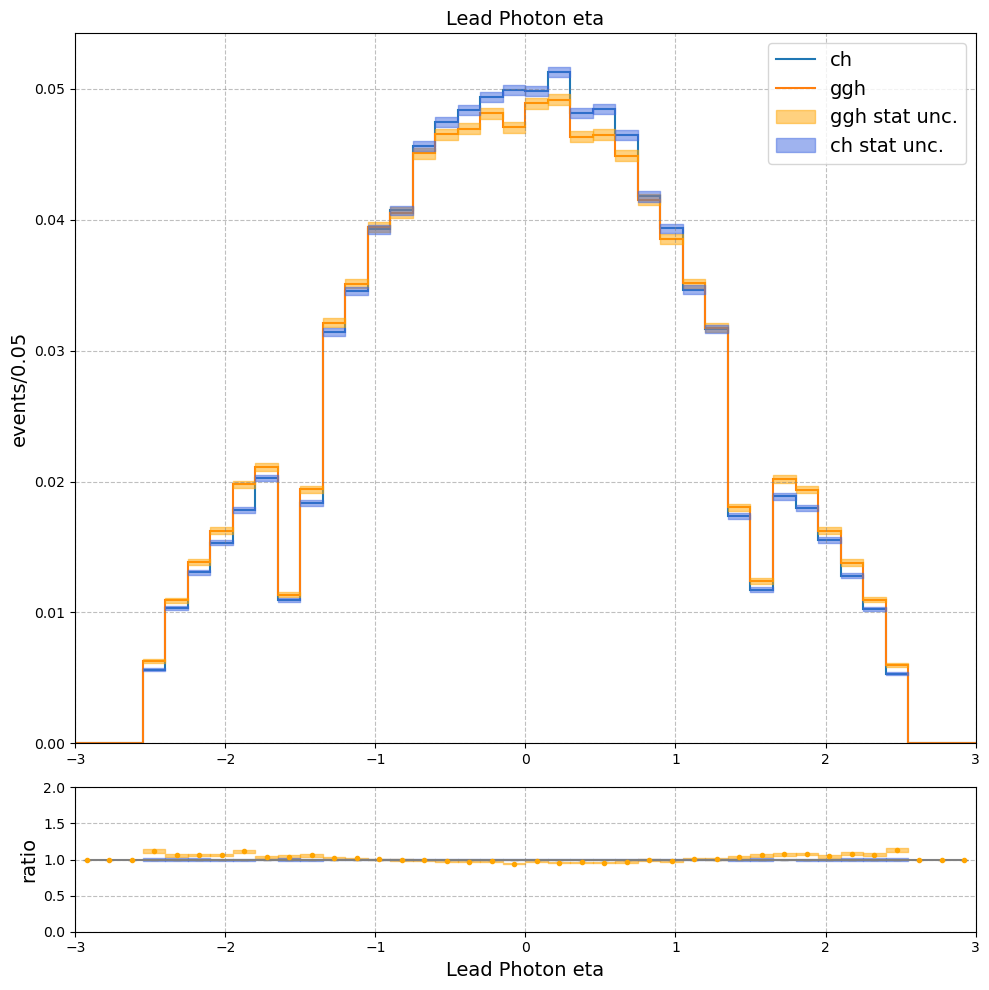

In [88]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_eta"
min_ = -3.
max_ = 3
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon eta', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon eta', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

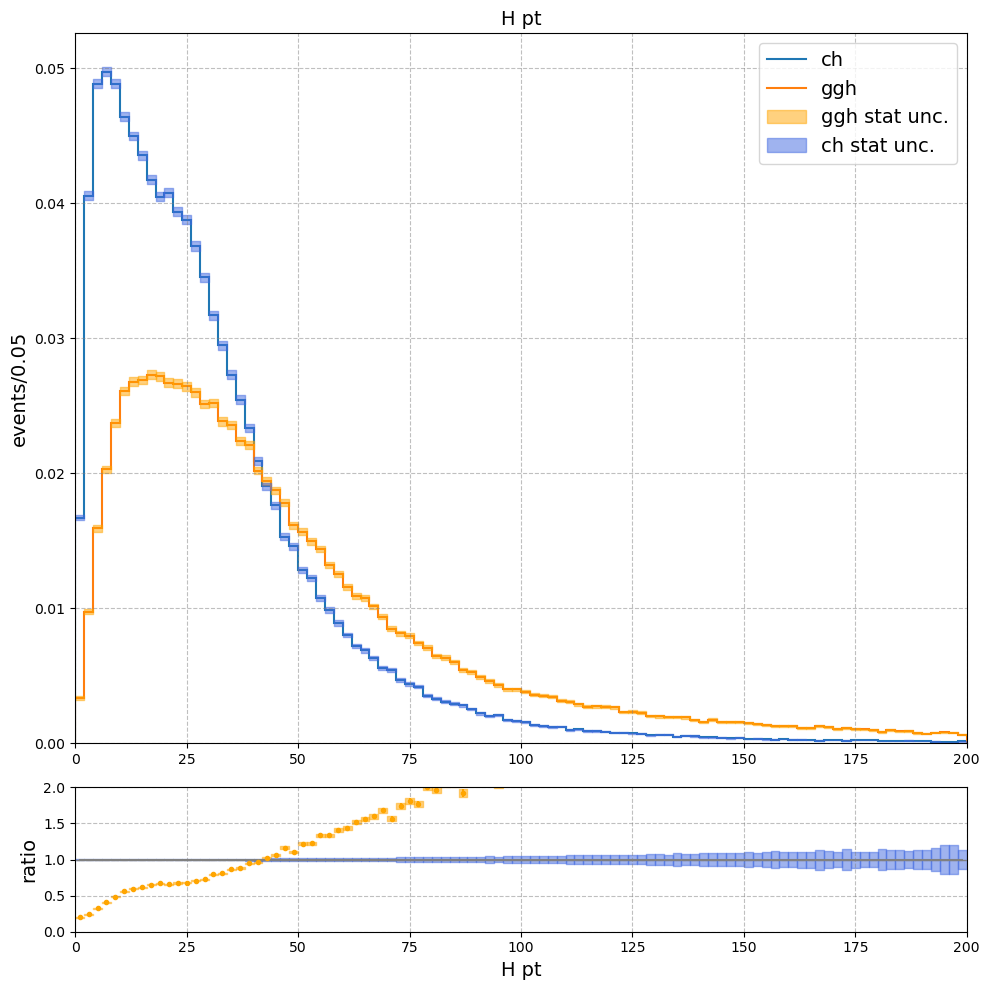

In [35]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "pt"
title = ""
for x in var.split("_"):
    title = title + x
title = "H pt"
min_ = 0.
max_ = 200
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

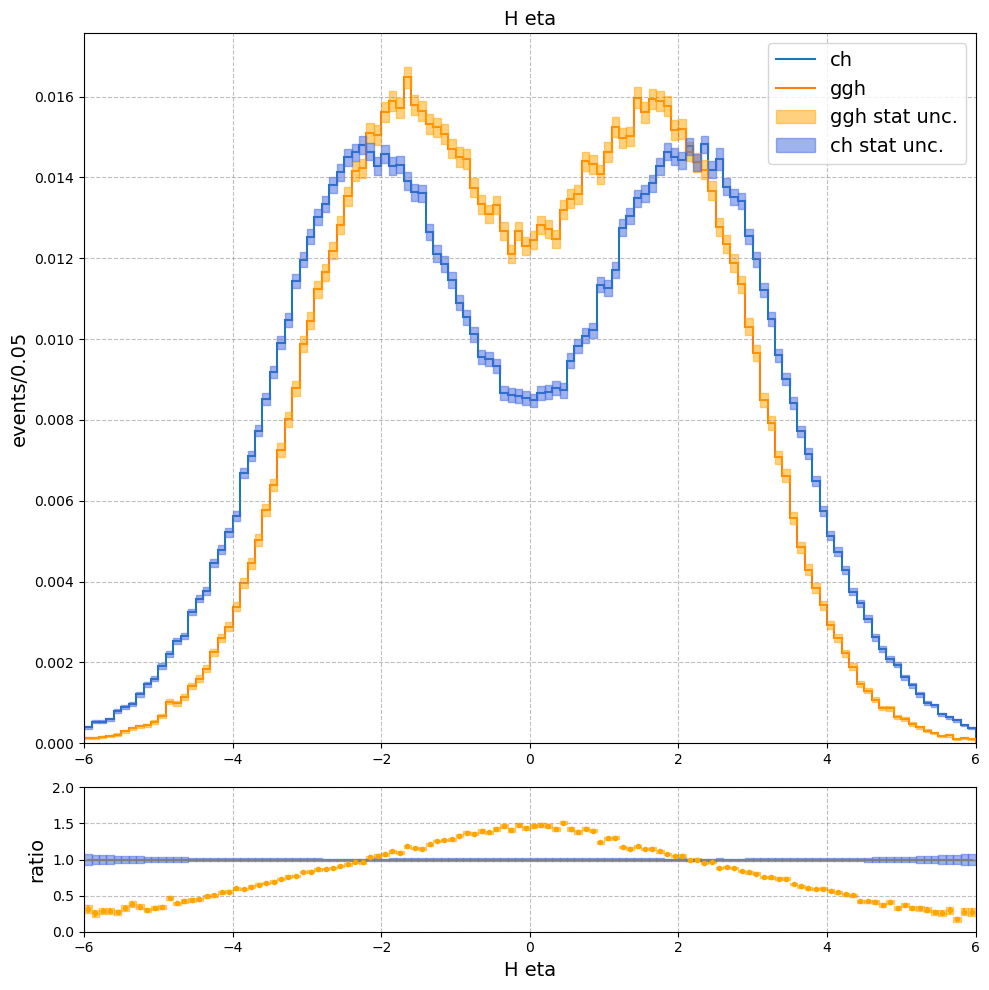

In [36]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "eta"
title = ""
for x in var.split("_"):
    title = title + x
title = "H eta"
min_ = -6.
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

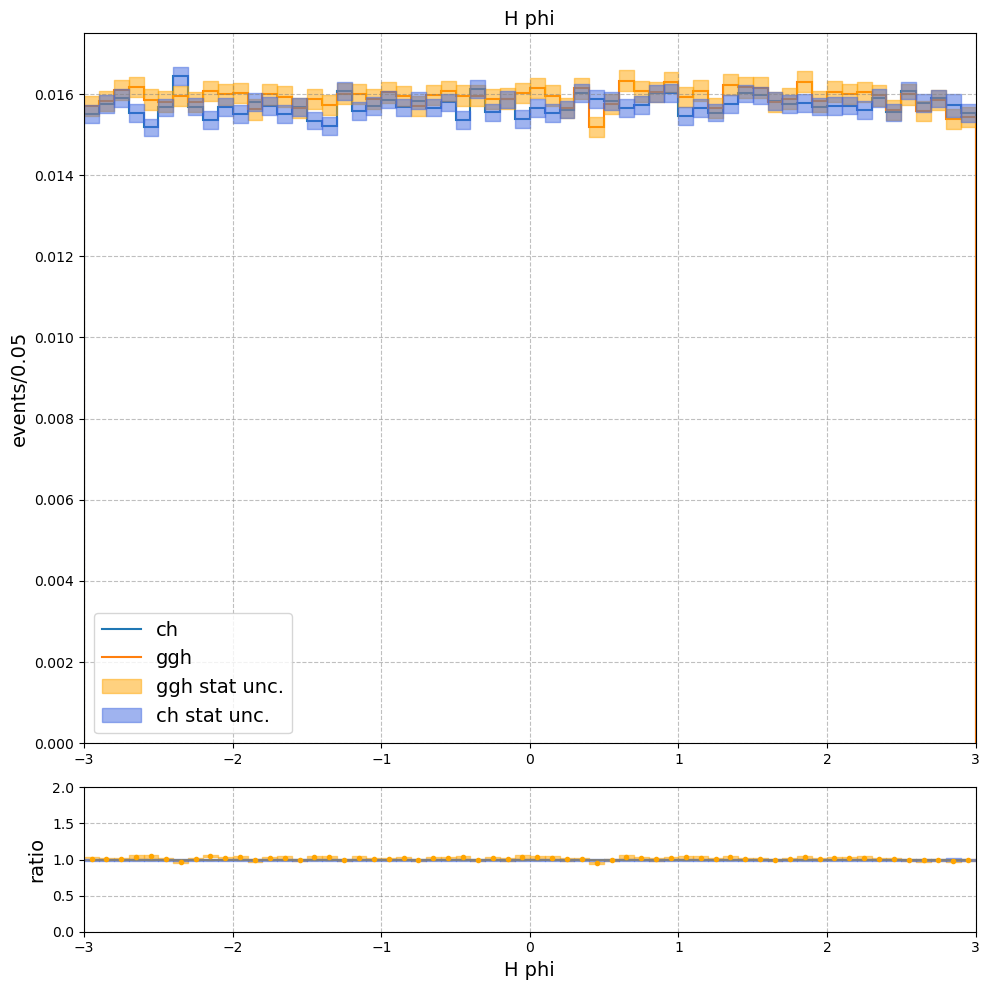

In [37]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "phi"
title = ""
for x in var.split("_"):
    title = title + x
title = "H phi"
min_ = -3.
max_ = 3
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/2664174471.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/2664174471.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/2664174471.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


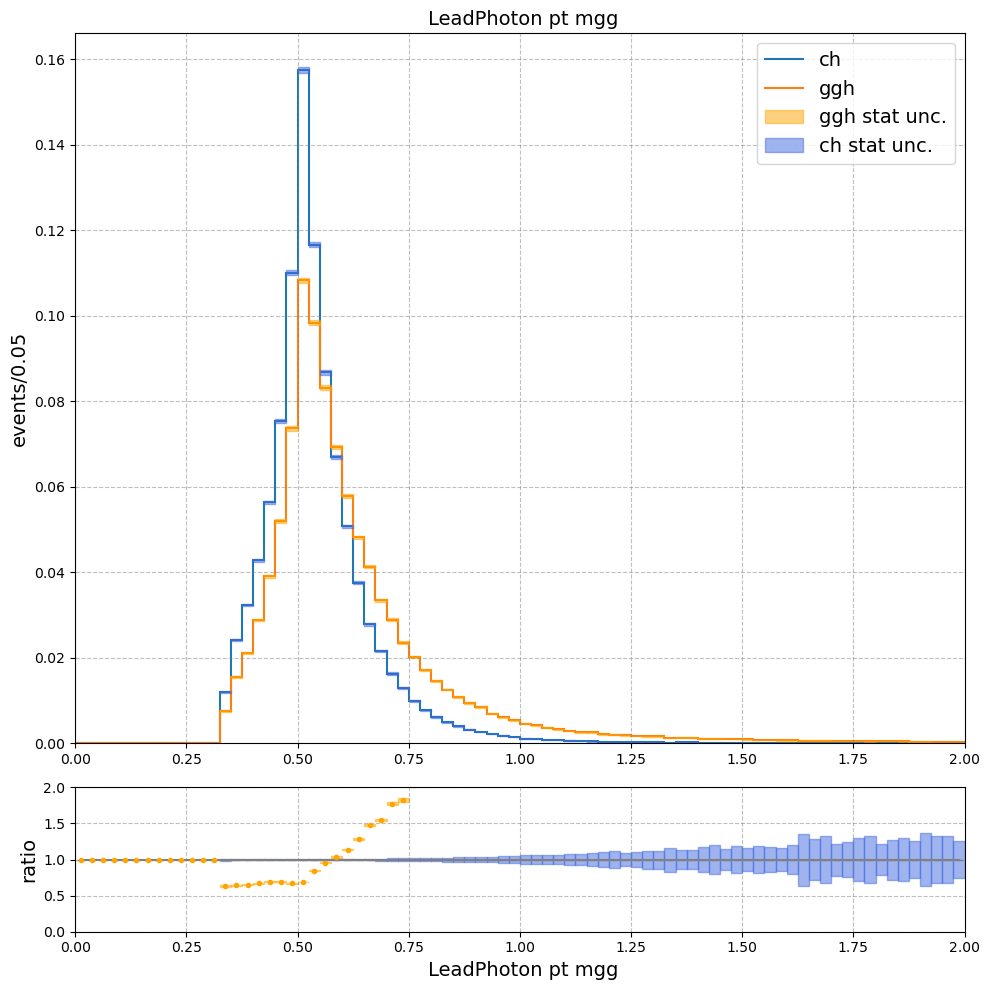

In [38]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_pt_mgg"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 2
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/621661515.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/621661515.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/621661515.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/621661515.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/621661515.

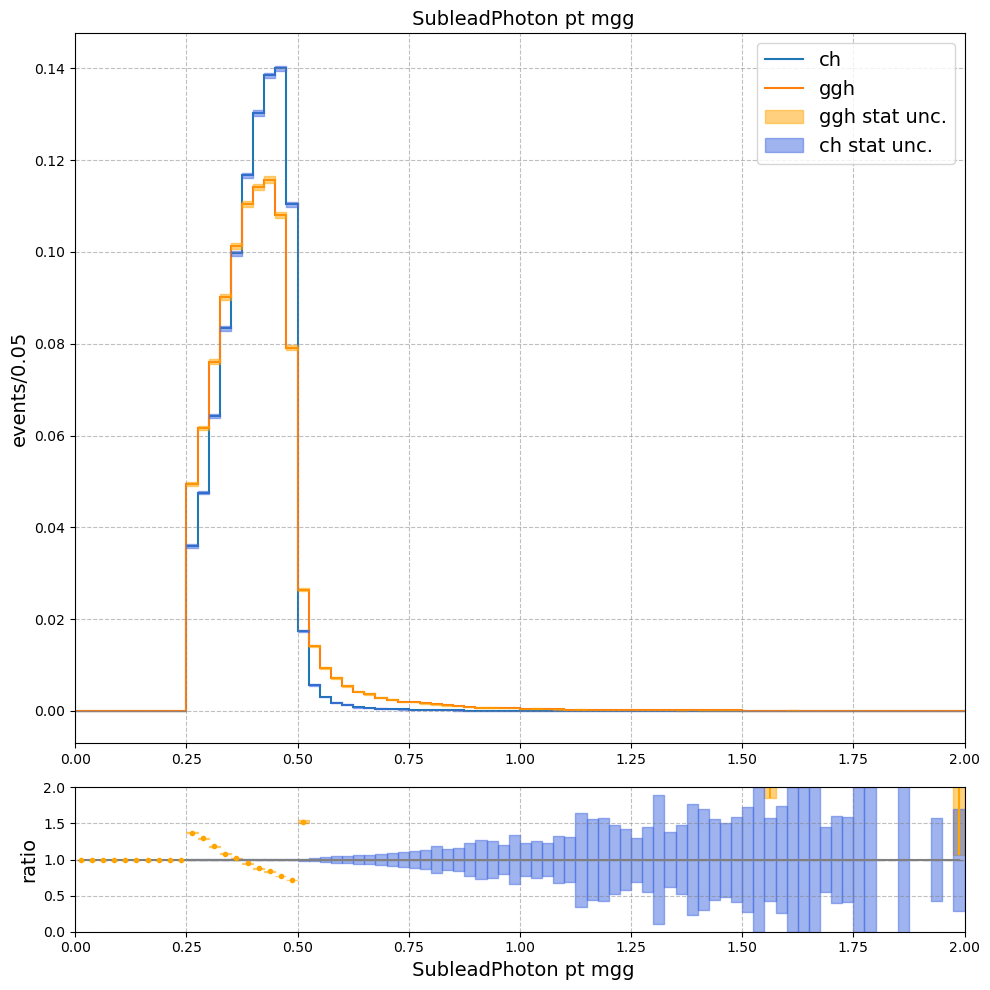

In [39]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "SubleadPhoton_pt_mgg"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 2
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

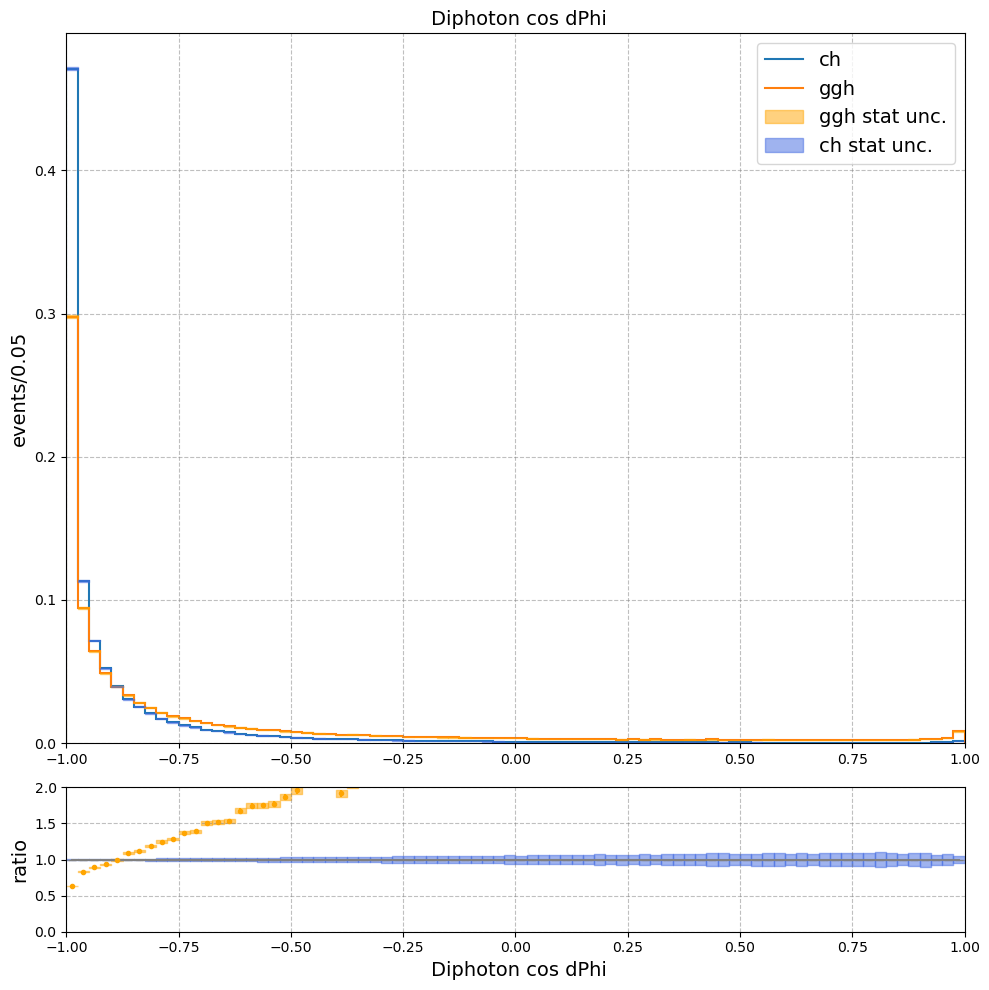

In [40]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "Diphoton_cos_dPhi"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -1.
max_ = 1
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/1163827082.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/1163827082.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/1163827082.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


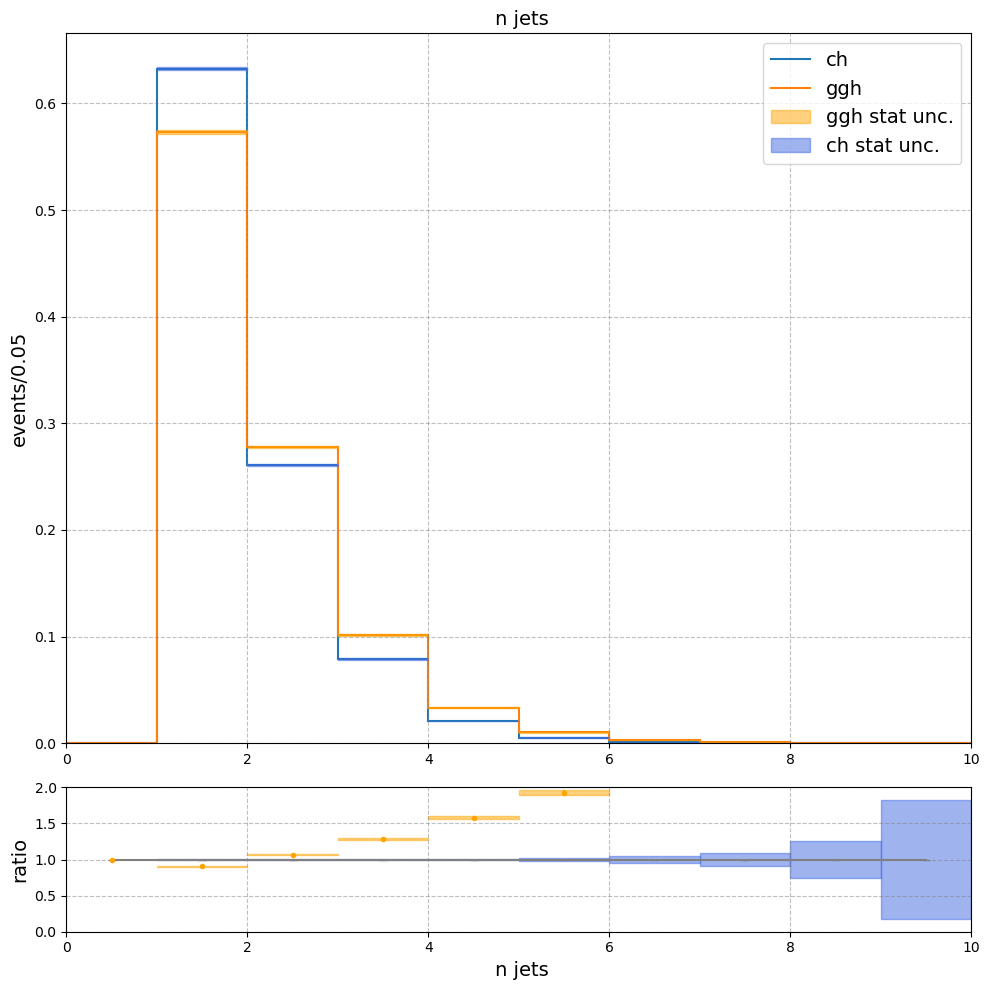

In [41]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "n_jets"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 10
nbins = 10

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/4171461478.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/4171461478.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/4171461478.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


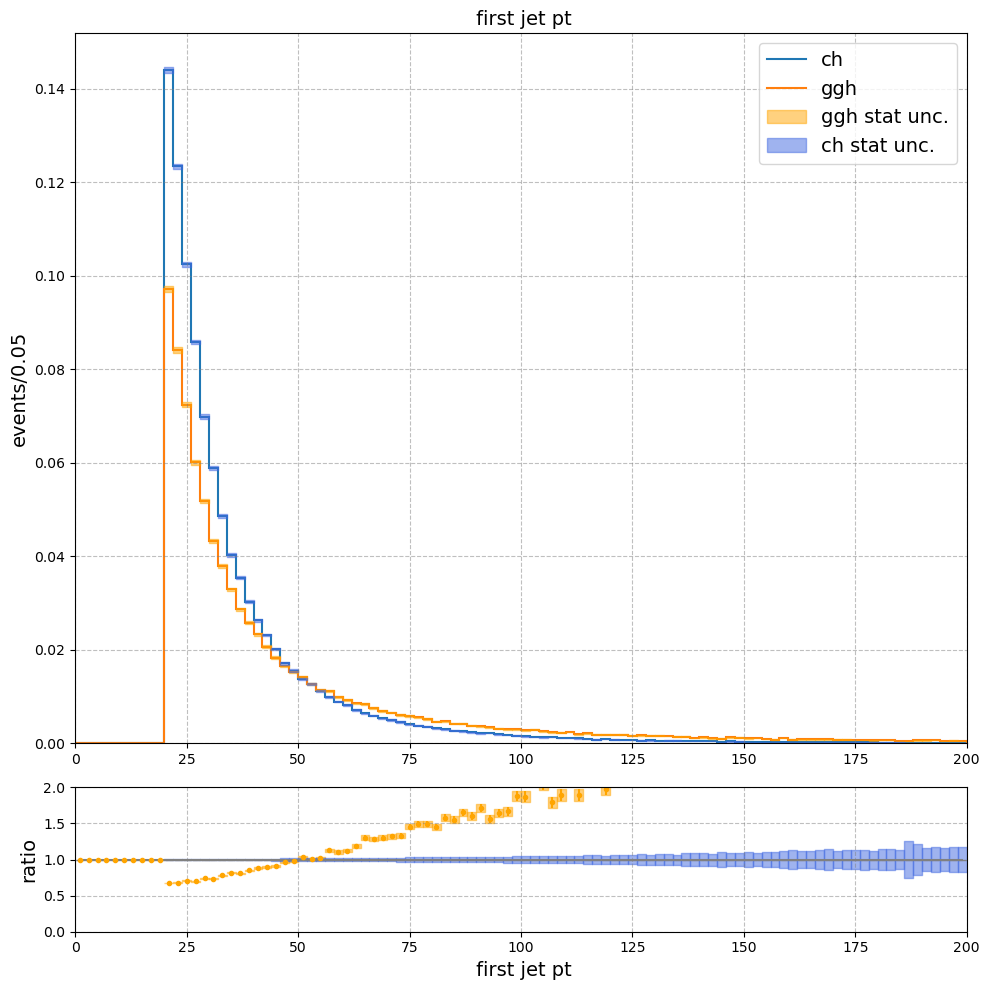

In [42]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_pt"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0.
max_ = 200
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/1218169719.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/1218169719.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/1218169719.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


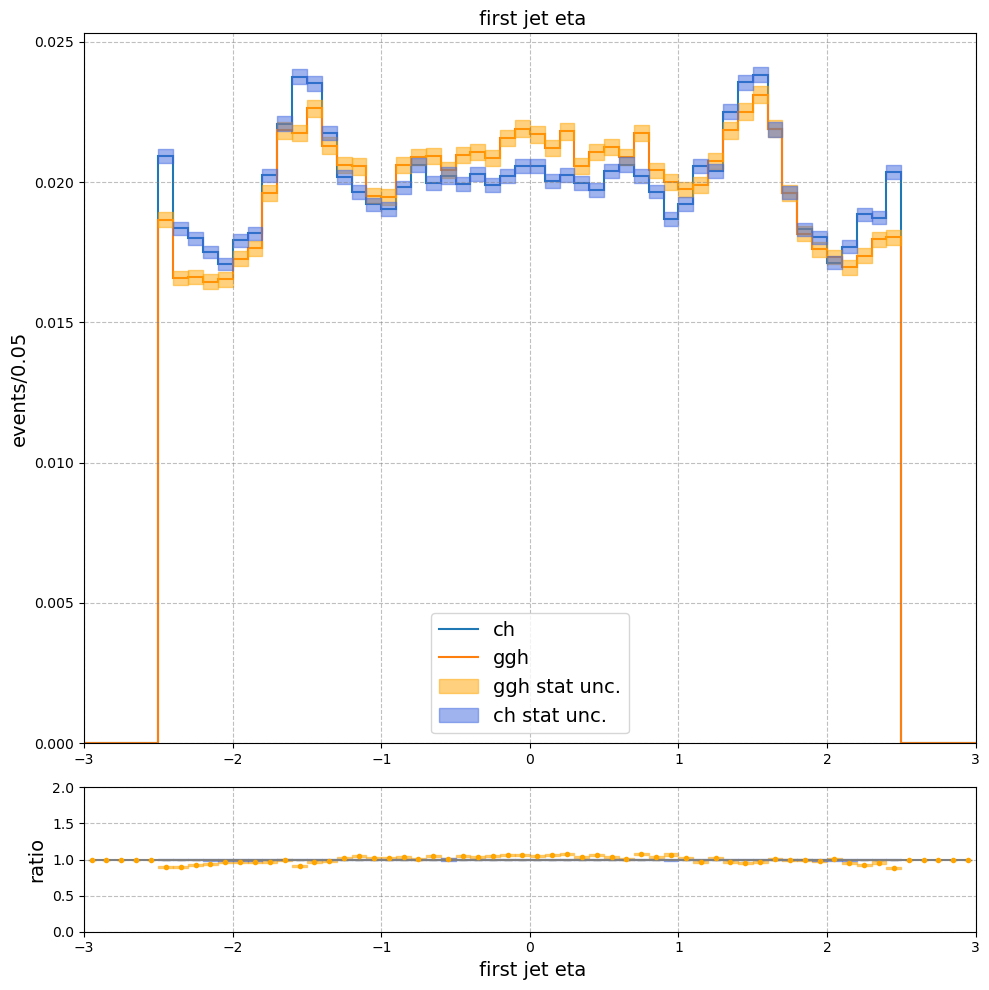

In [43]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_eta"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -3.
max_ = 3
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/1603542244.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/1603542244.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/1603542244.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


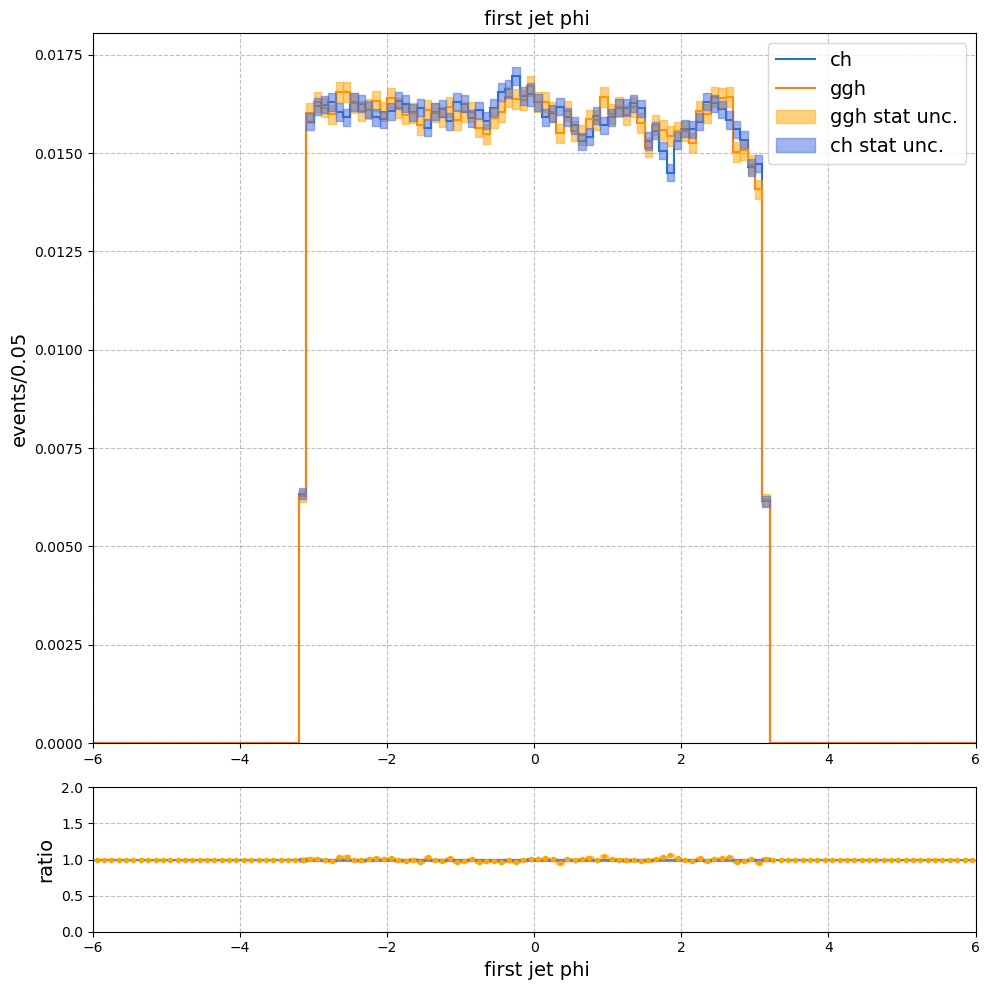

In [44]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_phi"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = mc["errs"]["ggh"]/mc["bins"]["ch"], color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

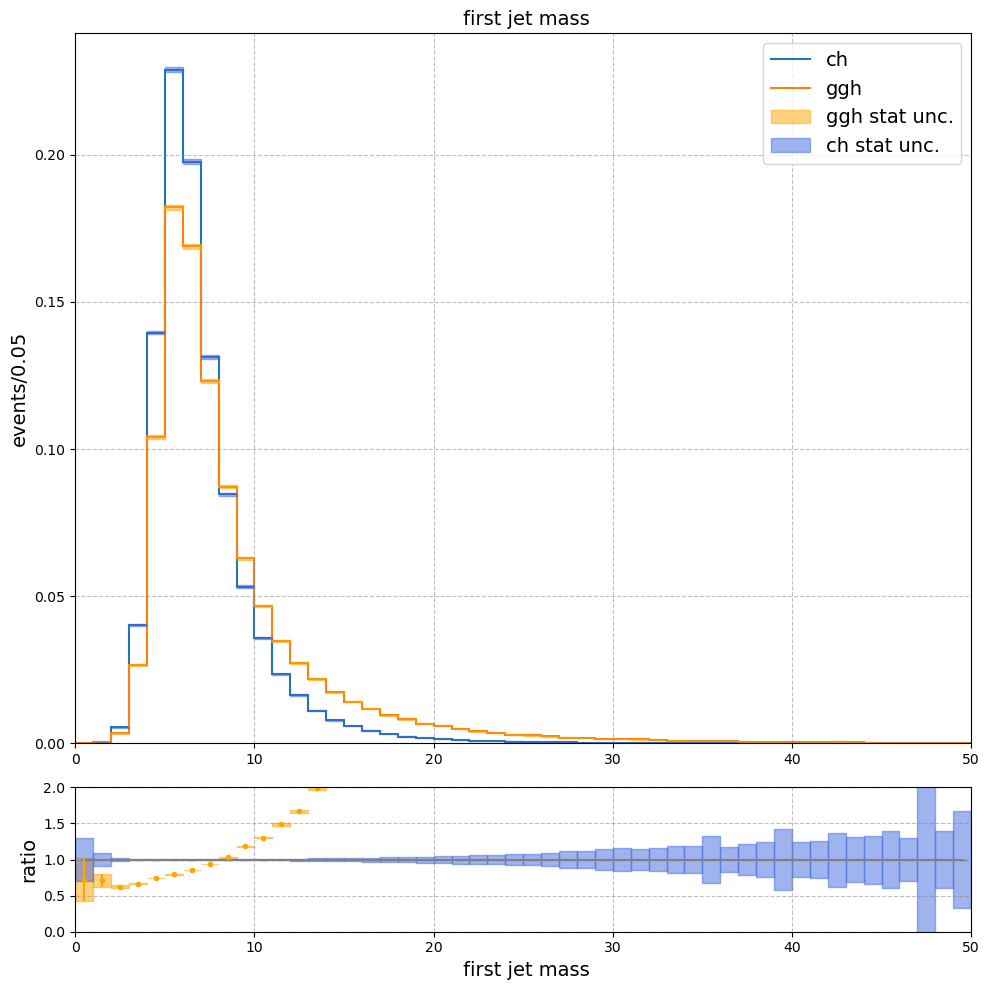

In [45]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_jet_mass"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 50
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/1108933258.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/1108933258.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/1108933258.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


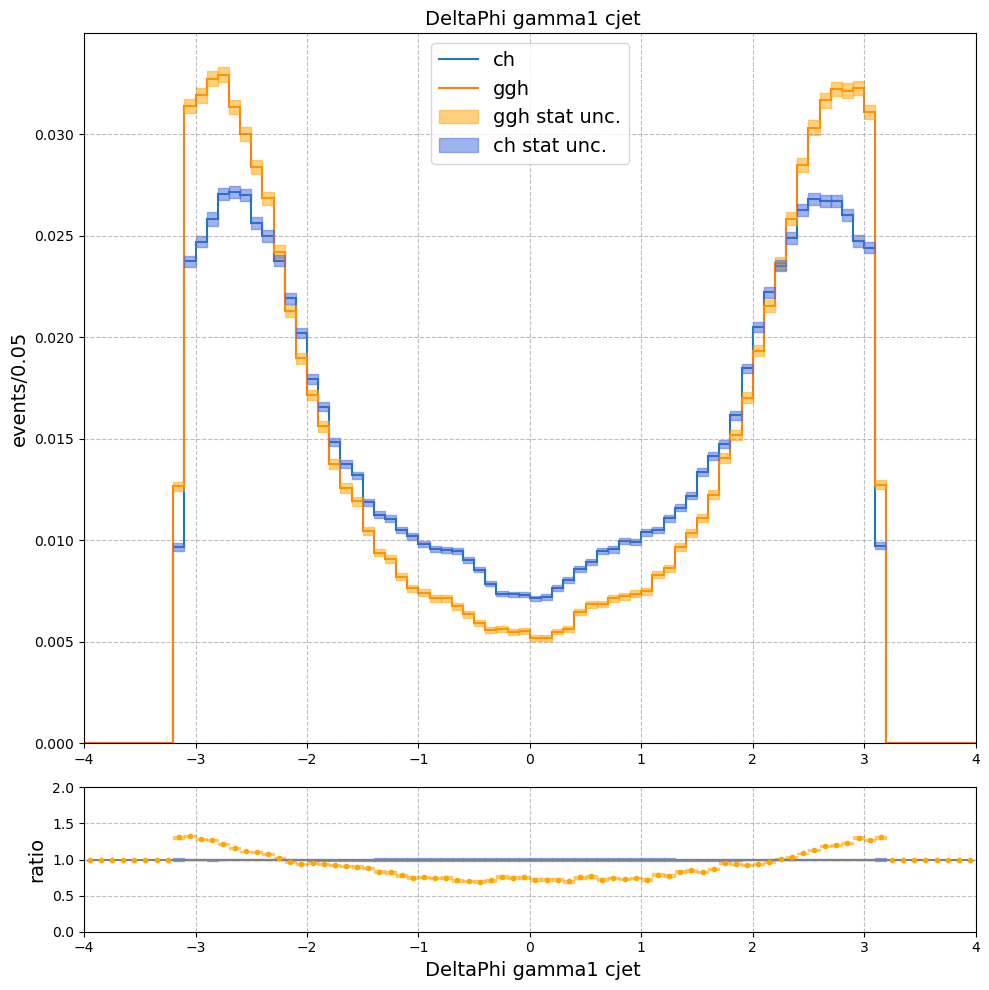

In [46]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "DeltaPhi_gamma1_cjet"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -4
max_ = 4
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/2280003665.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/2280003665.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/2280003665.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


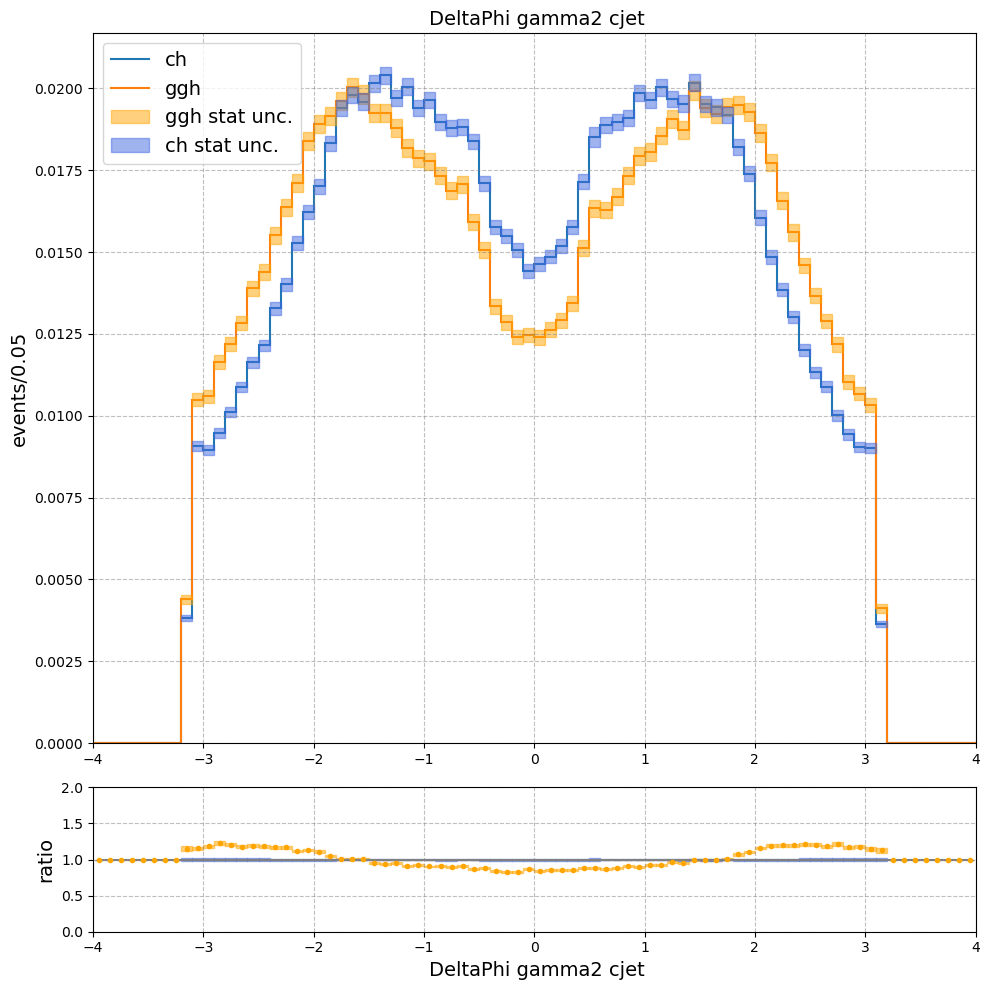

In [47]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "DeltaPhi_gamma2_cjet"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -4
max_ = 4
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

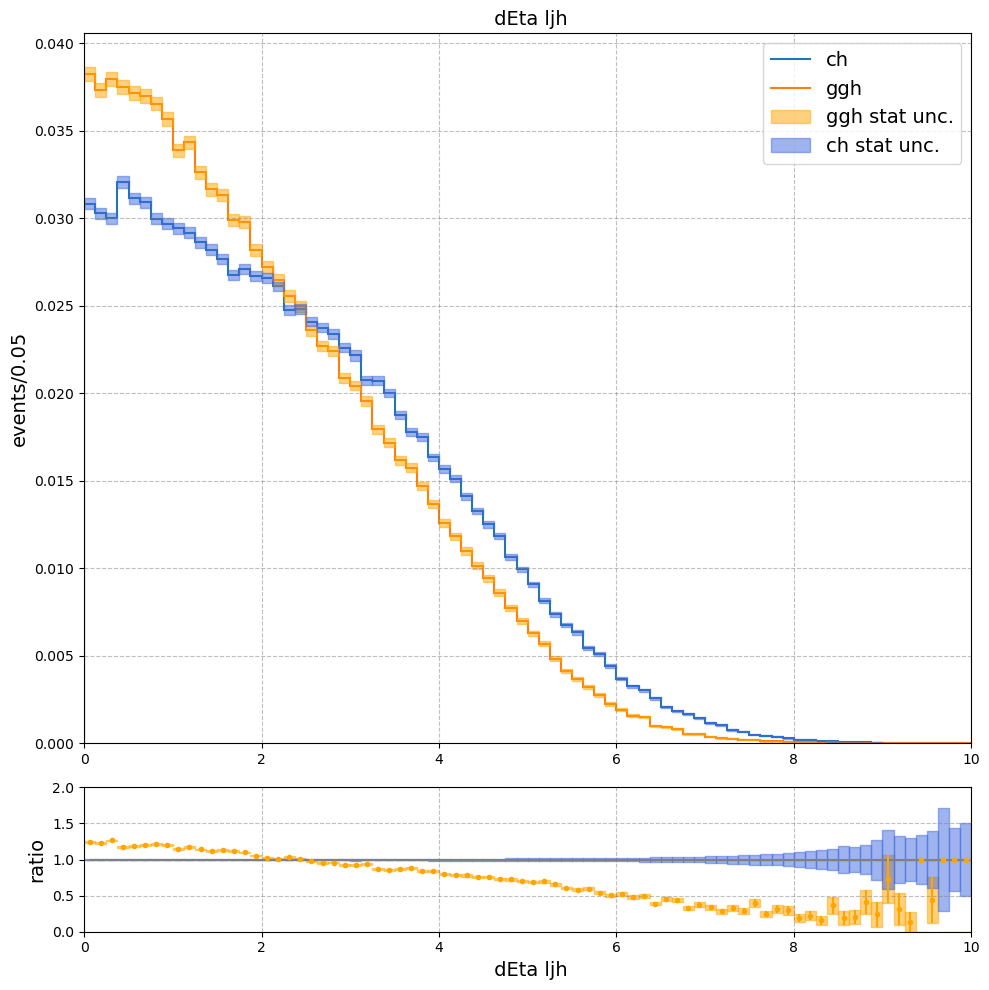

In [48]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dEta_ljh"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 10
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/2184813611.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/2184813611.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/2184813611.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/2184813611.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/218481

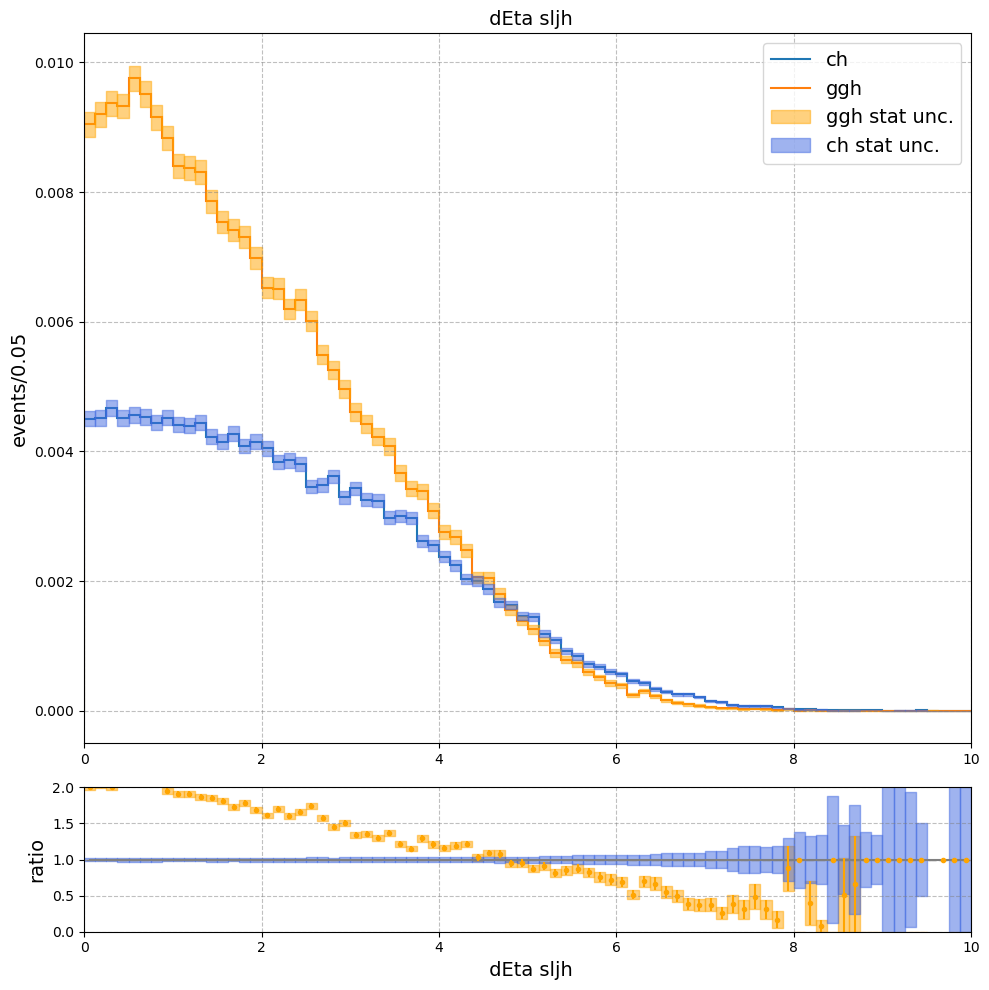

In [49]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dEta_sljh"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 10
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/1233181441.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/1233181441.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/1233181441.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


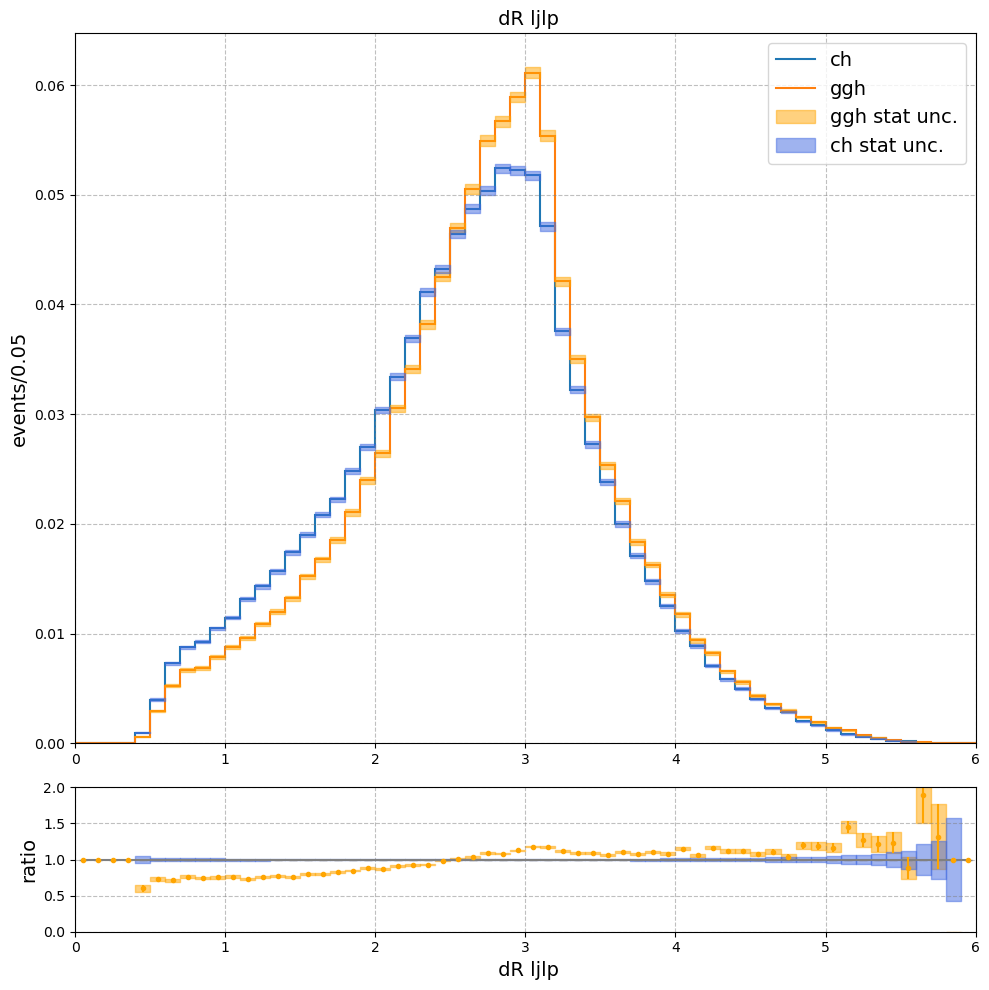

In [50]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dR_ljlp"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 6
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/2914907583.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/2914907583.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/2914907583.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


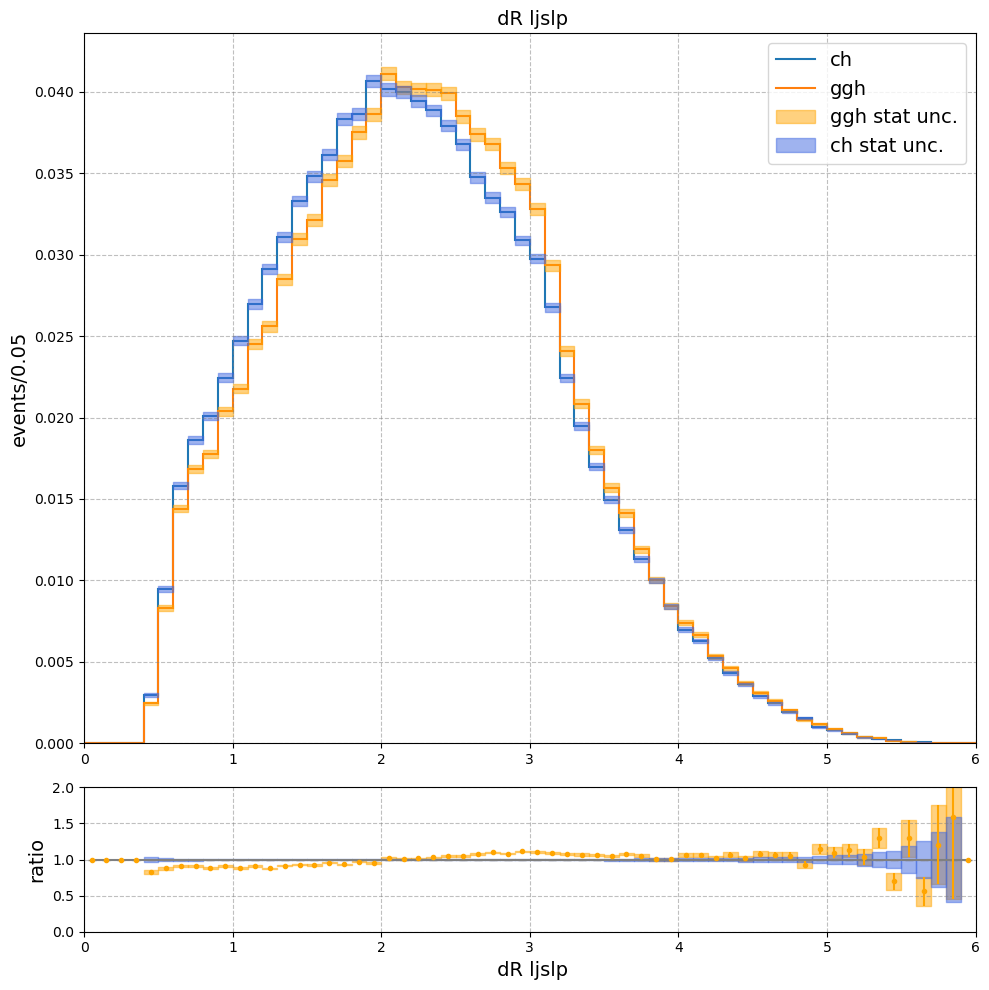

In [51]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "dR_ljslp"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 6
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/205628860.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/205628860.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/205628860.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


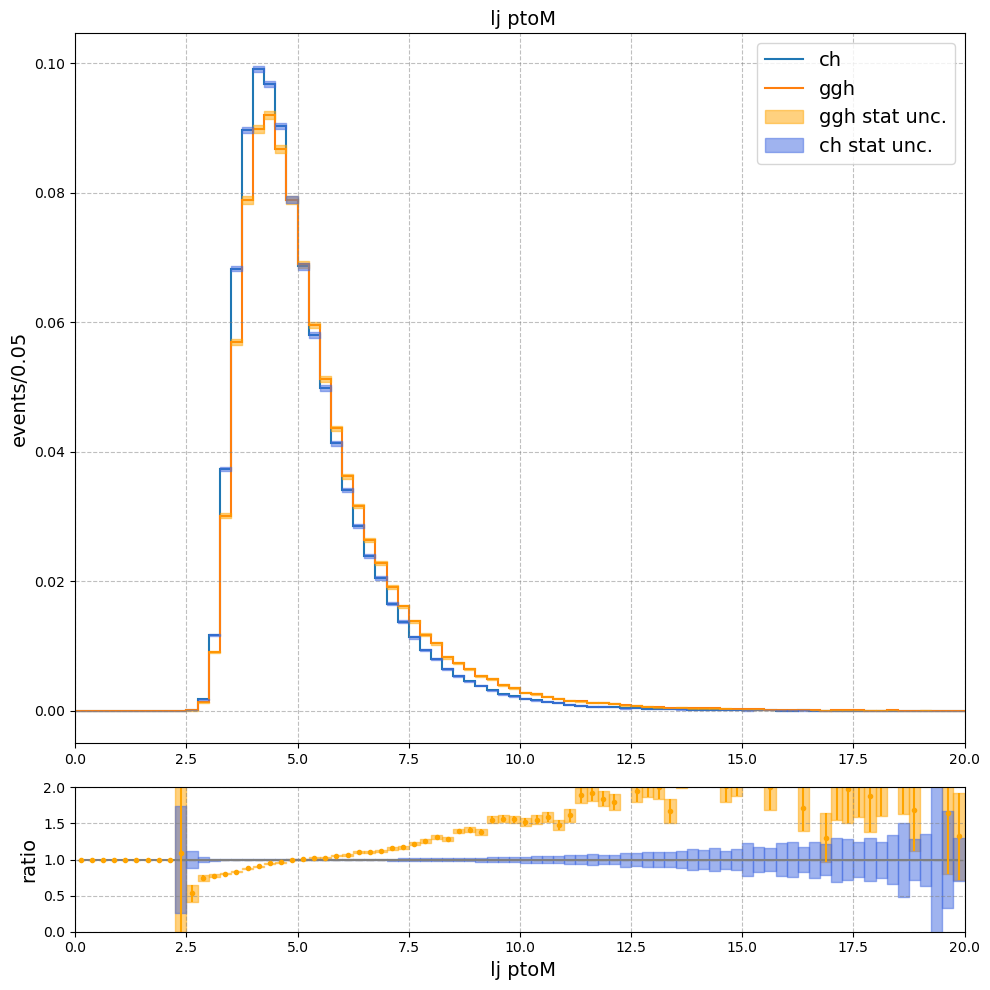

In [52]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "lj_ptoM"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 20
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/3764214450.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3764214450.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/3764214450.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")
/tmp/ipykernel_18909/37642144

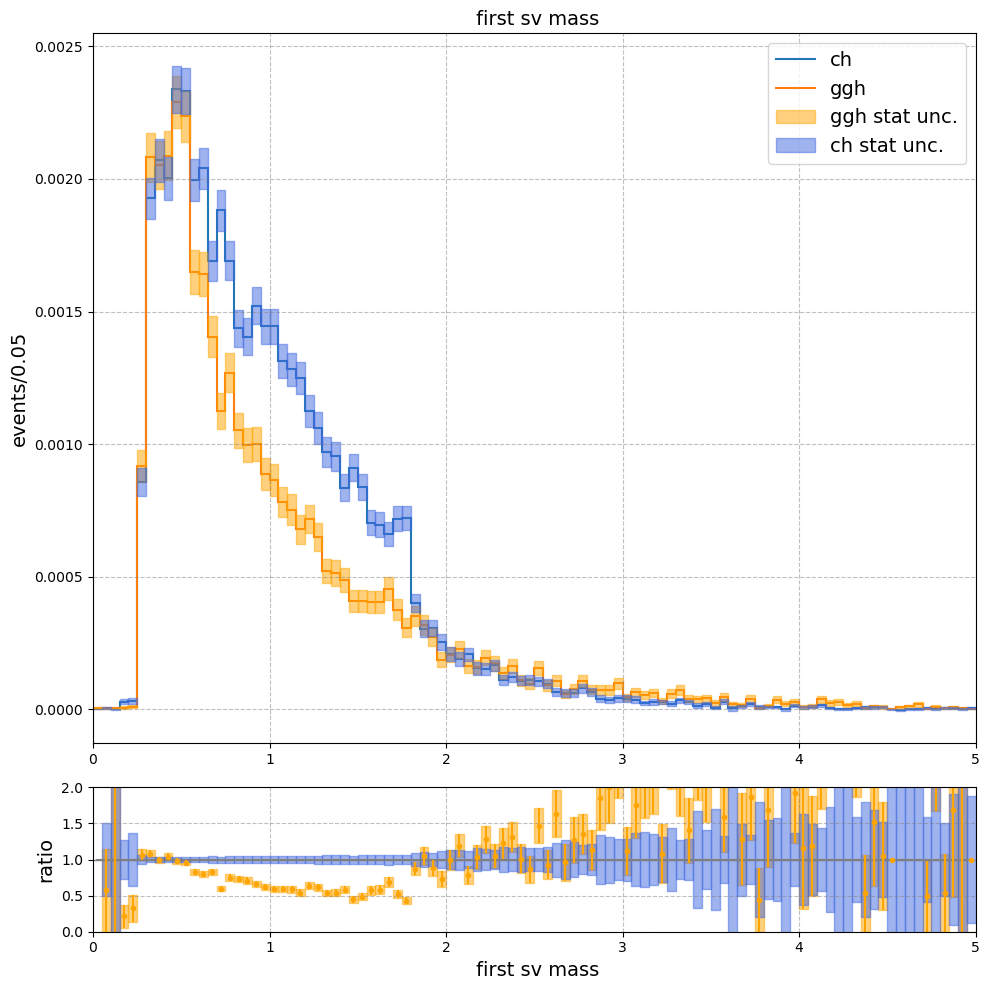

In [89]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_mass"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 5
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_18909/3571248552.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3571248552.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3571248552.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


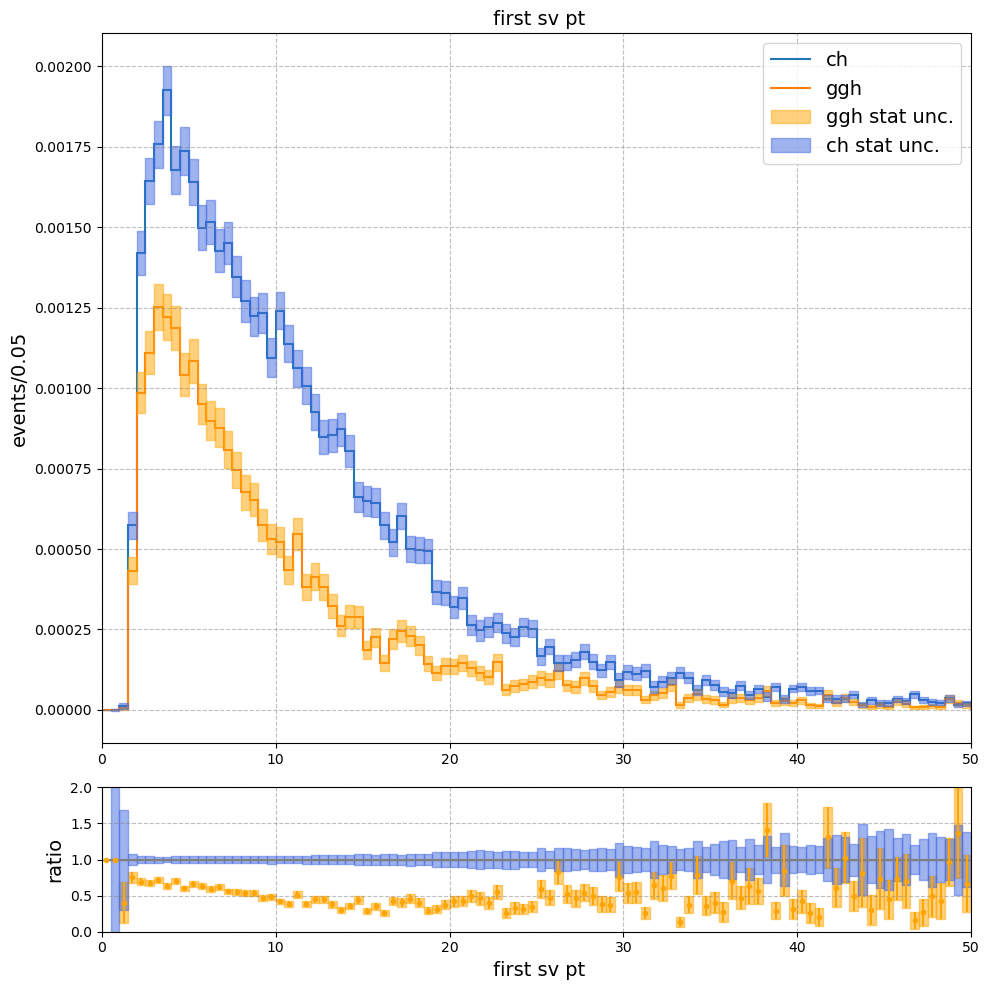

In [90]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_pt"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 50
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

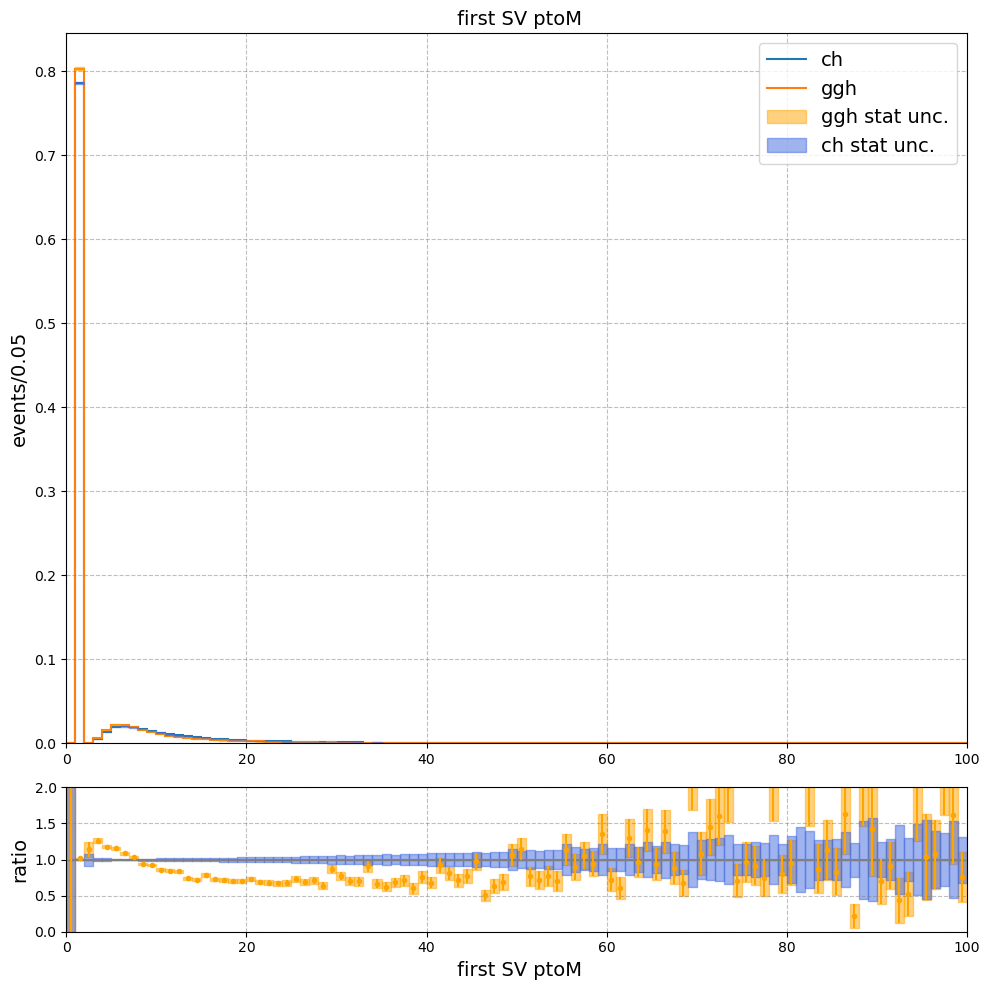

1.0
1.0000000000000004


In [91]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_SV_ptoM"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 100
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_63179/525592084.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_63179/525592084.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_63179/525592084.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


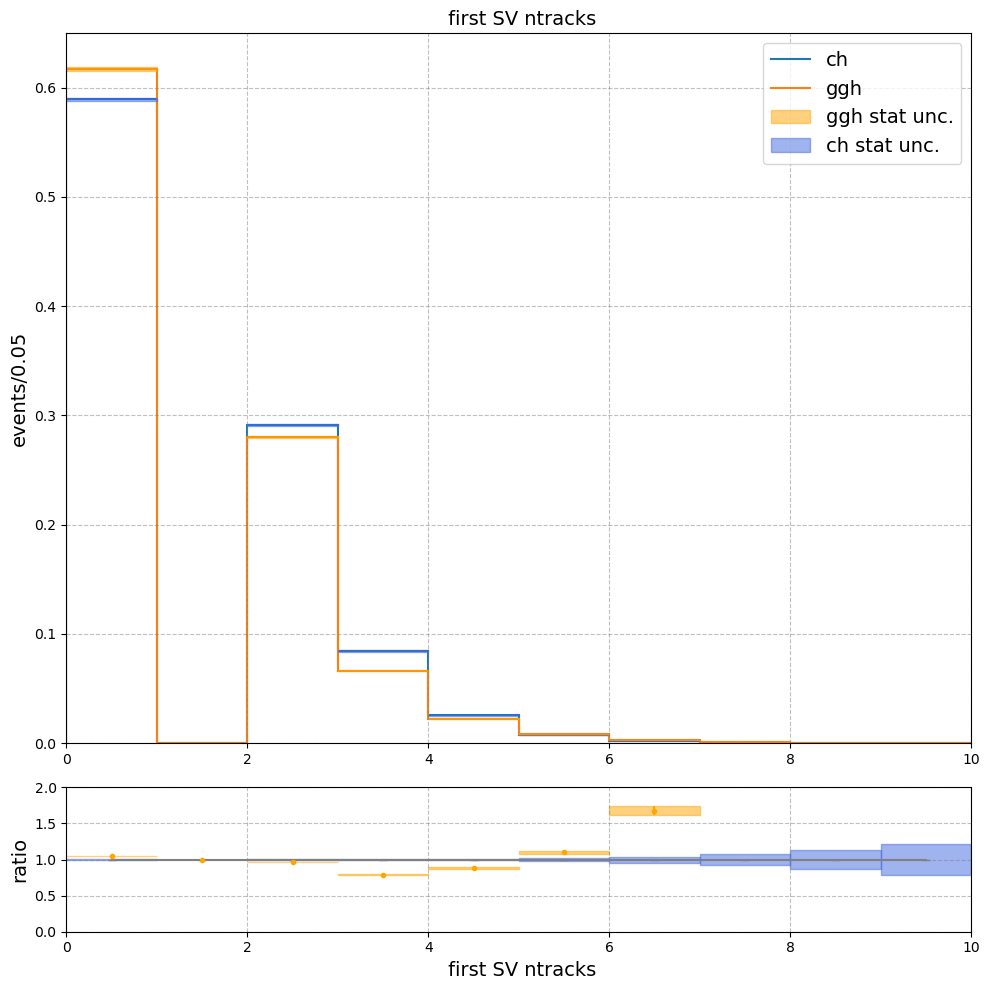

1.0
1.0000000000000004


In [100]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_SV_ntracks"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 10
nbins = 10

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/4222568690.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/4222568690.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/4222568690.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


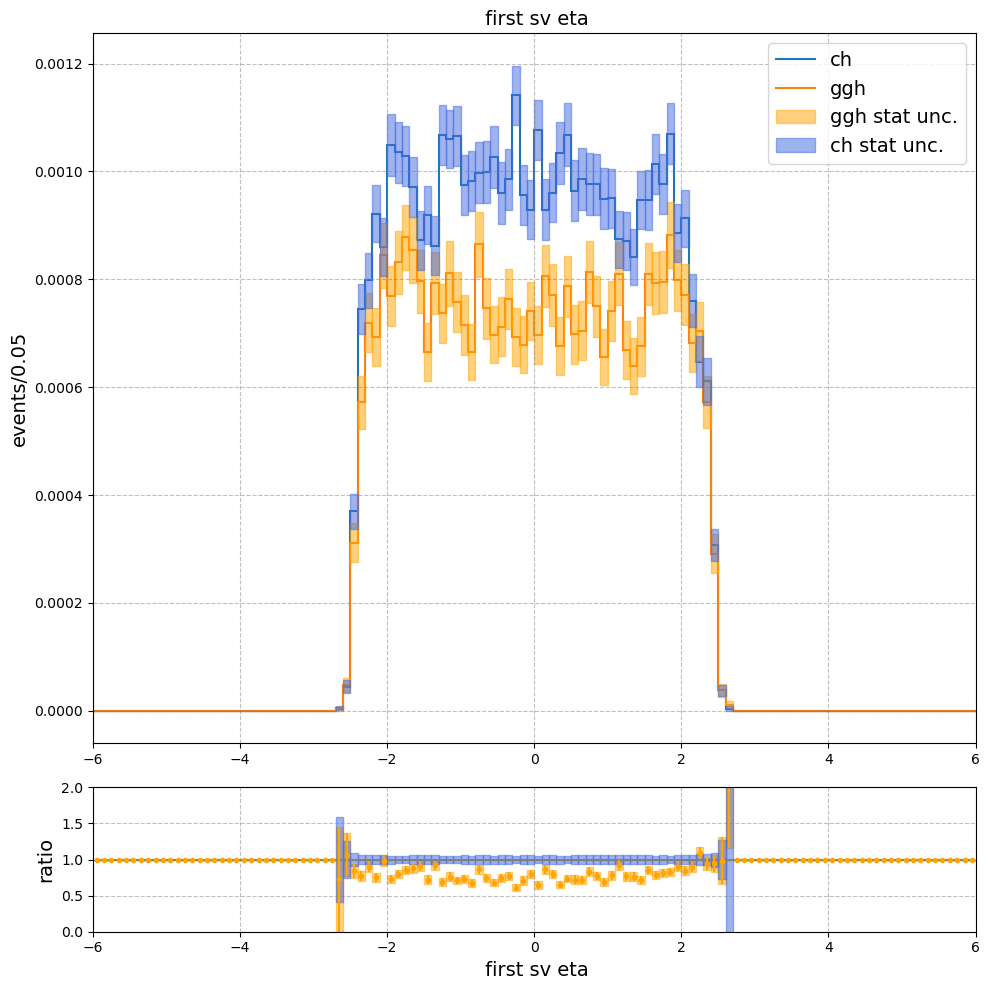

1.0
1.0000000000000004


In [92]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_eta"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/2568088307.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/2568088307.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/2568088307.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


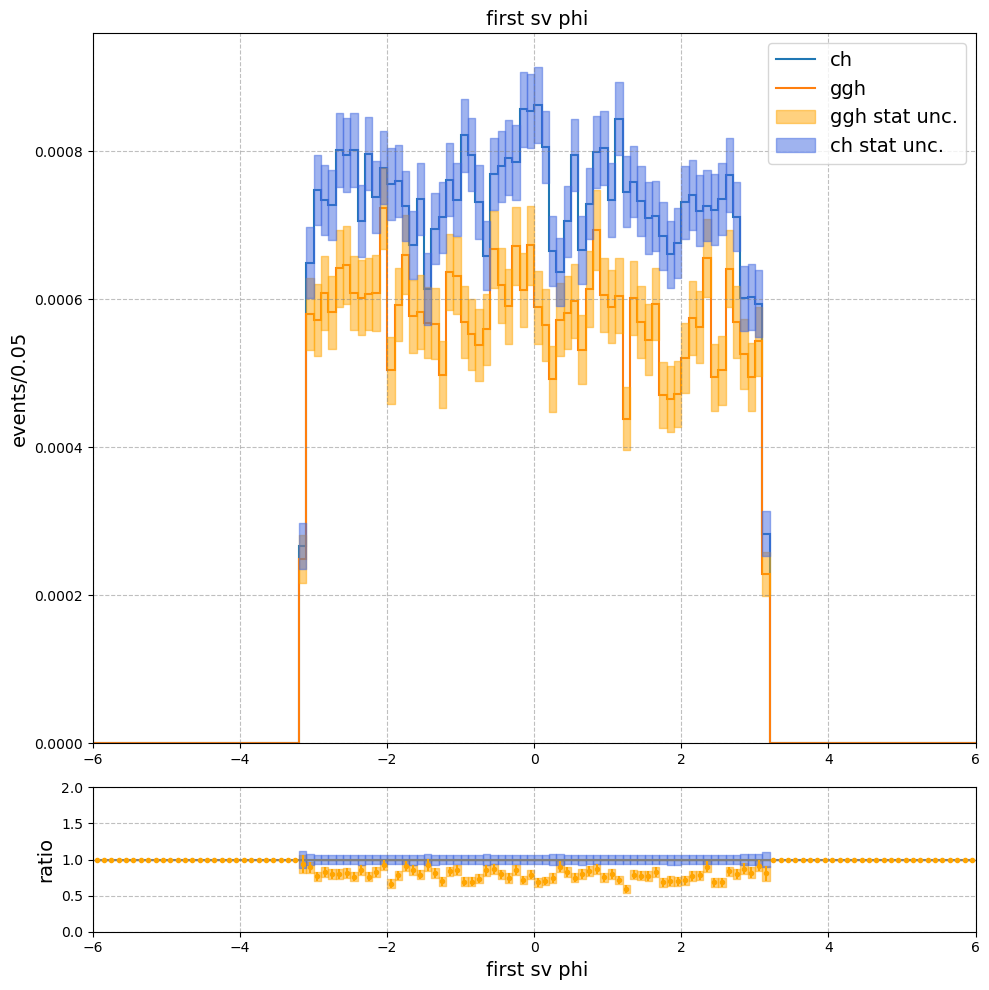

1.0
1.0000000000000004


In [93]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_phi"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

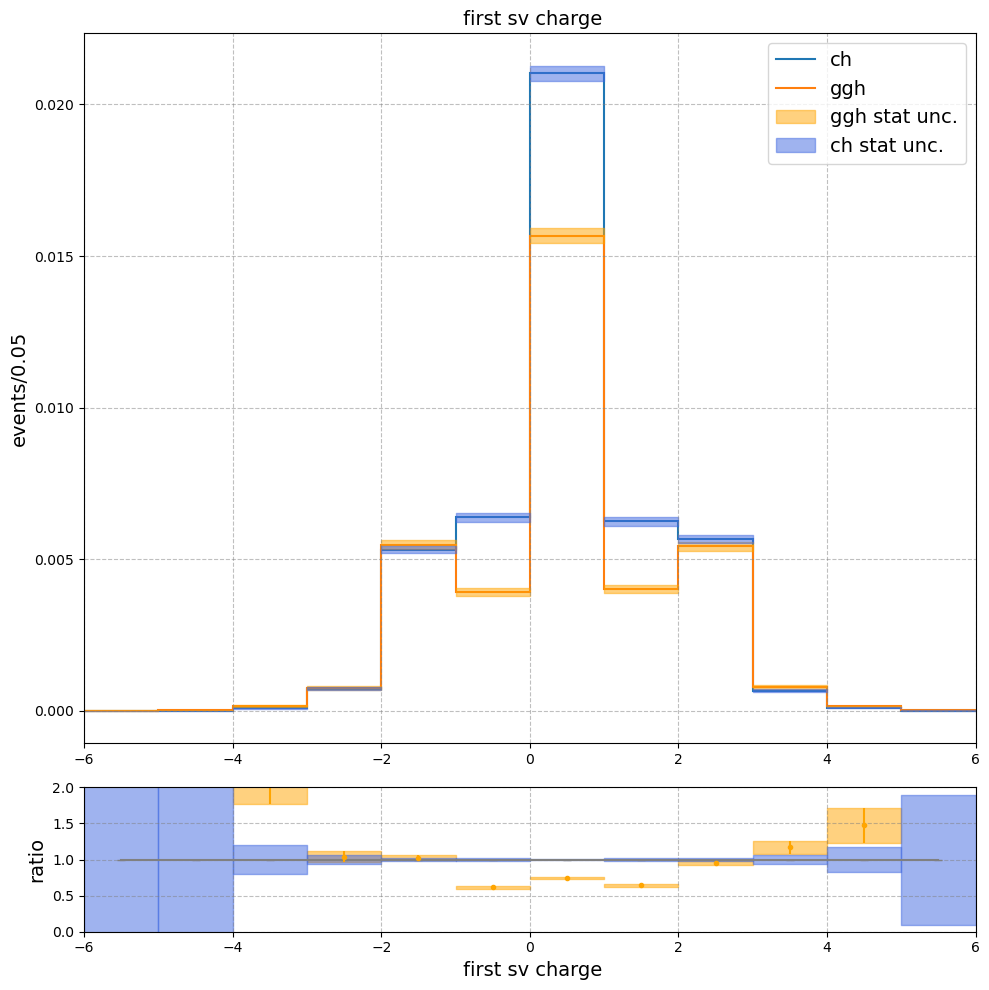

1.0
1.0000000000000004


In [94]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_charge"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = -6
max_ = 6
nbins = 12

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/3513458064.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3513458064.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3513458064.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")


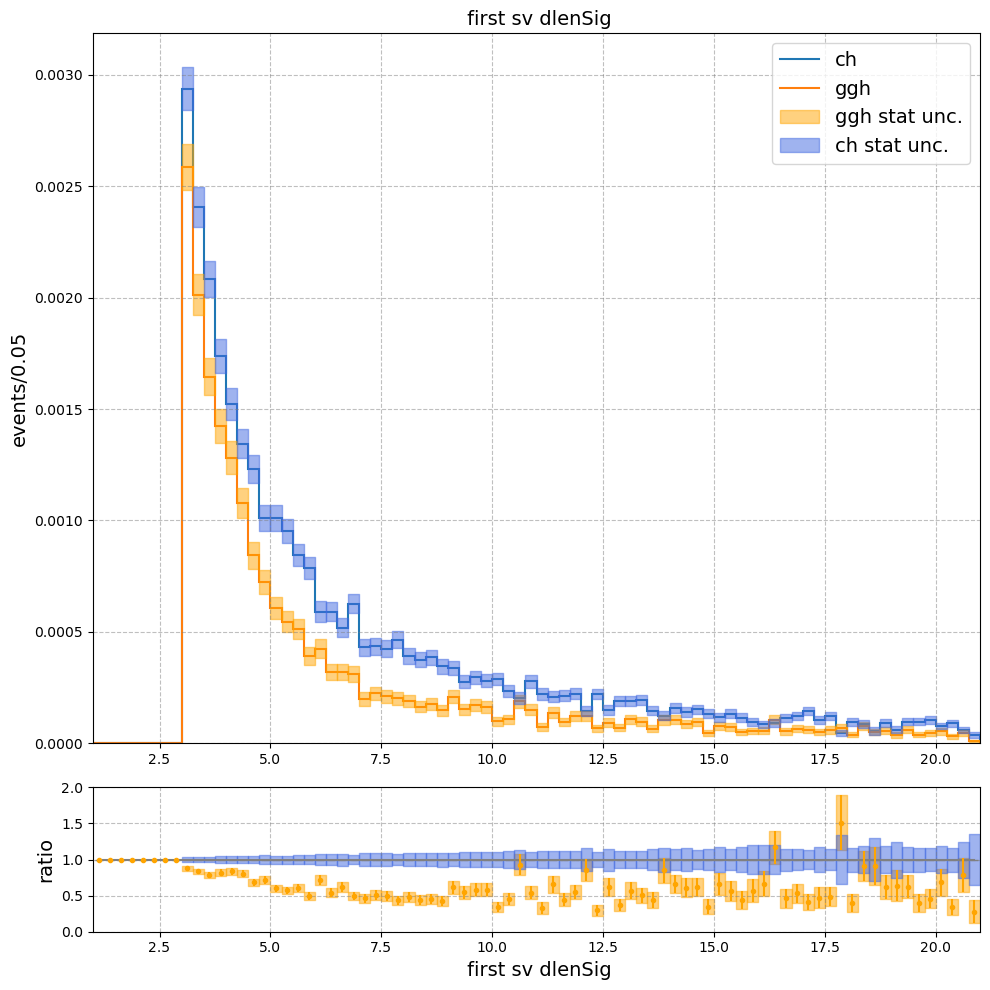

1.0
1.0000000000000004


In [95]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_dlenSig"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 1
max_ = 21
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/3799984955.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3799984955.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3799984955.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3799984955.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/379998

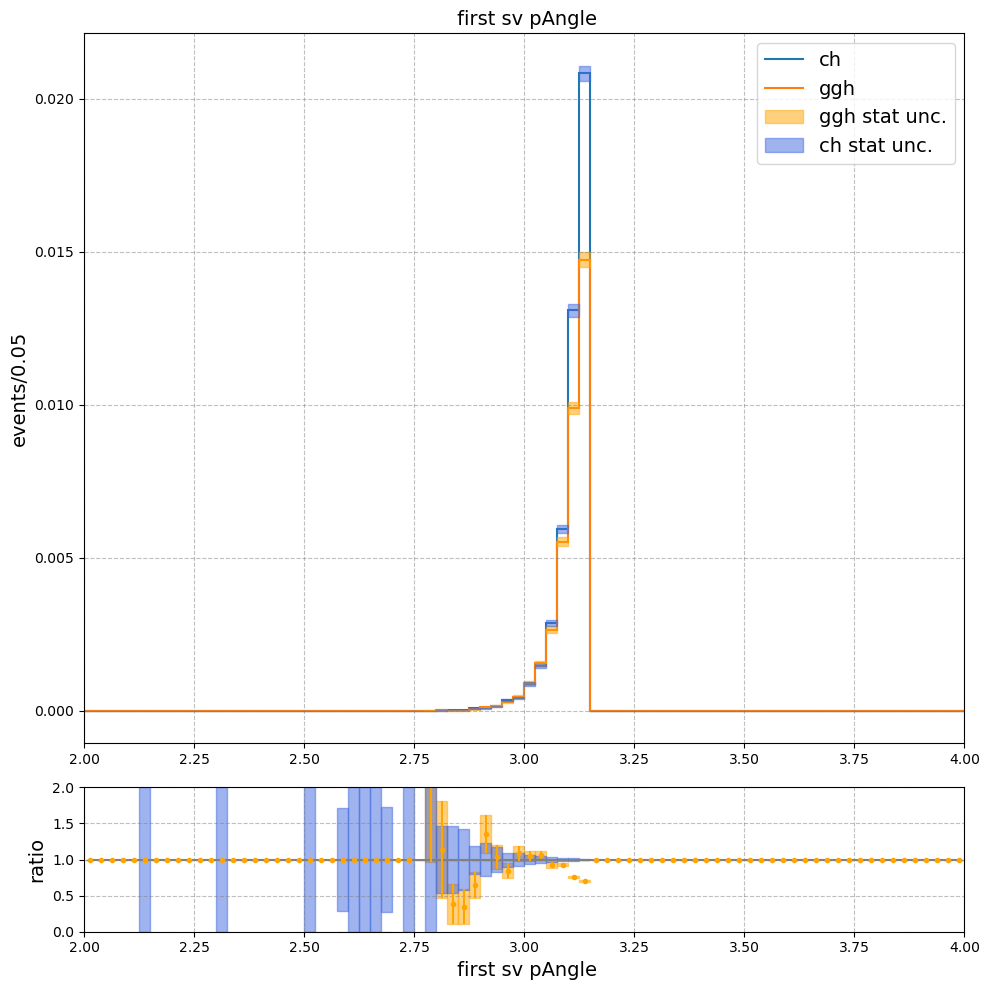

1.0
1.0000000000000004


In [96]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_pAngle"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 2
max_ = 4
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/3151981319.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3151981319.py:100: RuntimeWarning: invalid value encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/3151981319.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/tmp/ipykernel_18909/3151981319.py:104: RuntimeWarning: invalid value encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/315198

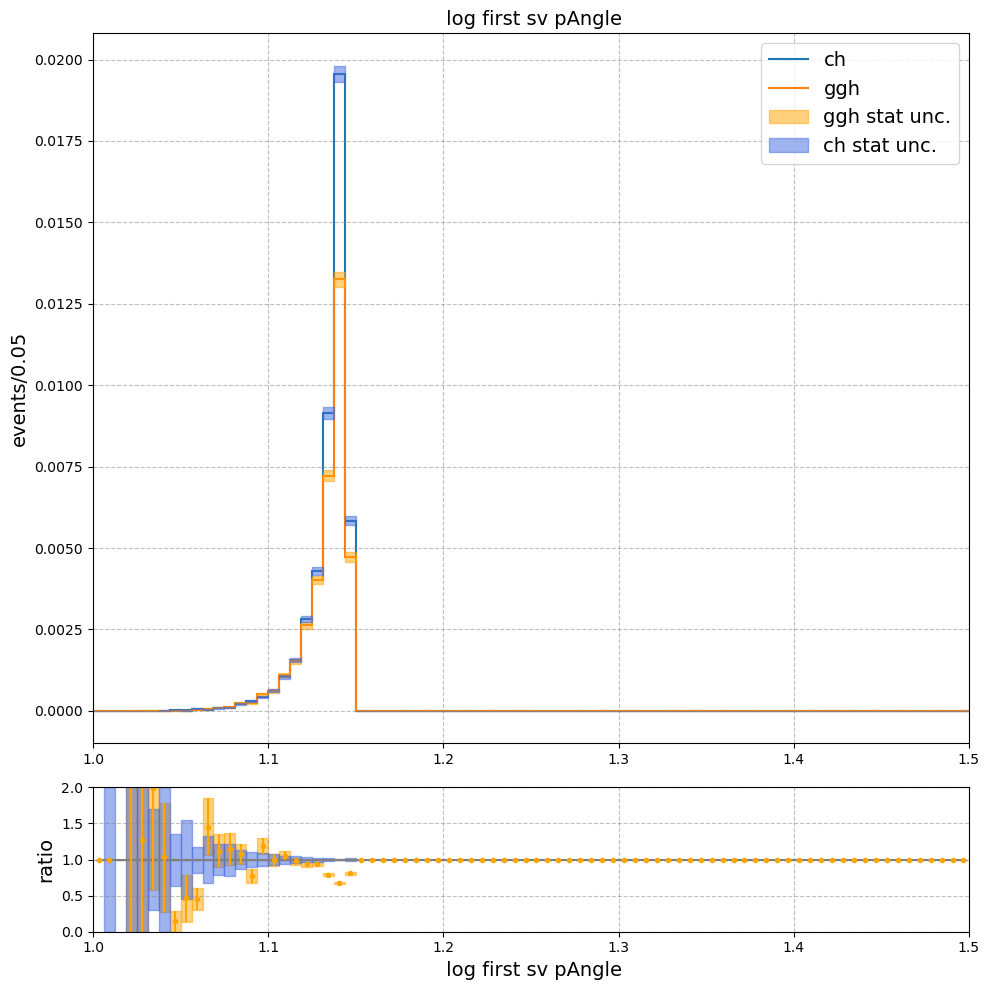

1.0
1.0000000000000004


In [102]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "log_first_sv_pAngle"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 1
max_ = 1.5
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

/tmp/ipykernel_18909/614630724.py:100: RuntimeWarning: divide by zero encountered in divide
  mc["bins"]["ggh"] / mc["bins"]["ch"],
/tmp/ipykernel_18909/614630724.py:104: RuntimeWarning: divide by zero encountered in divide
  ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")
/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3680: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_18909/614630724.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")
/tmp/ipykernel_18909/614630724.p

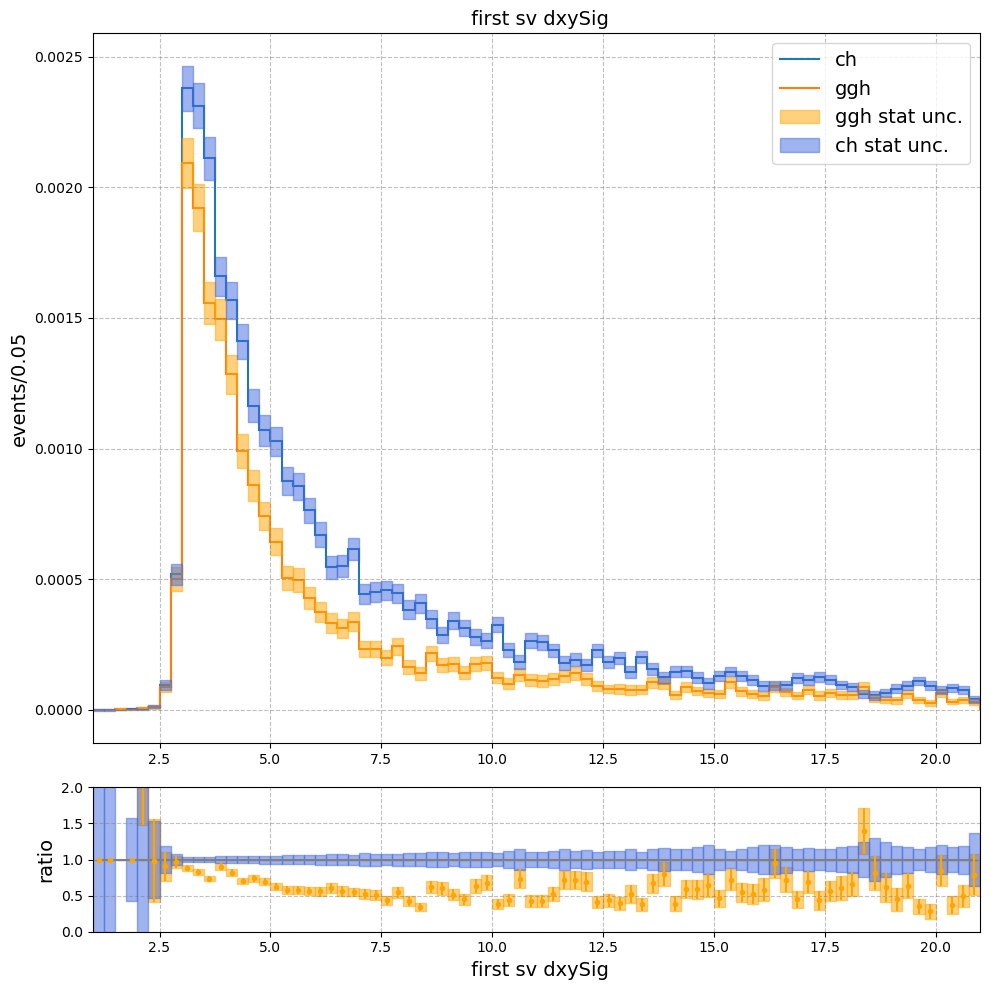

1.0
1.0000000000000004


In [103]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_sv_dxySig"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 1
max_ = 21
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))

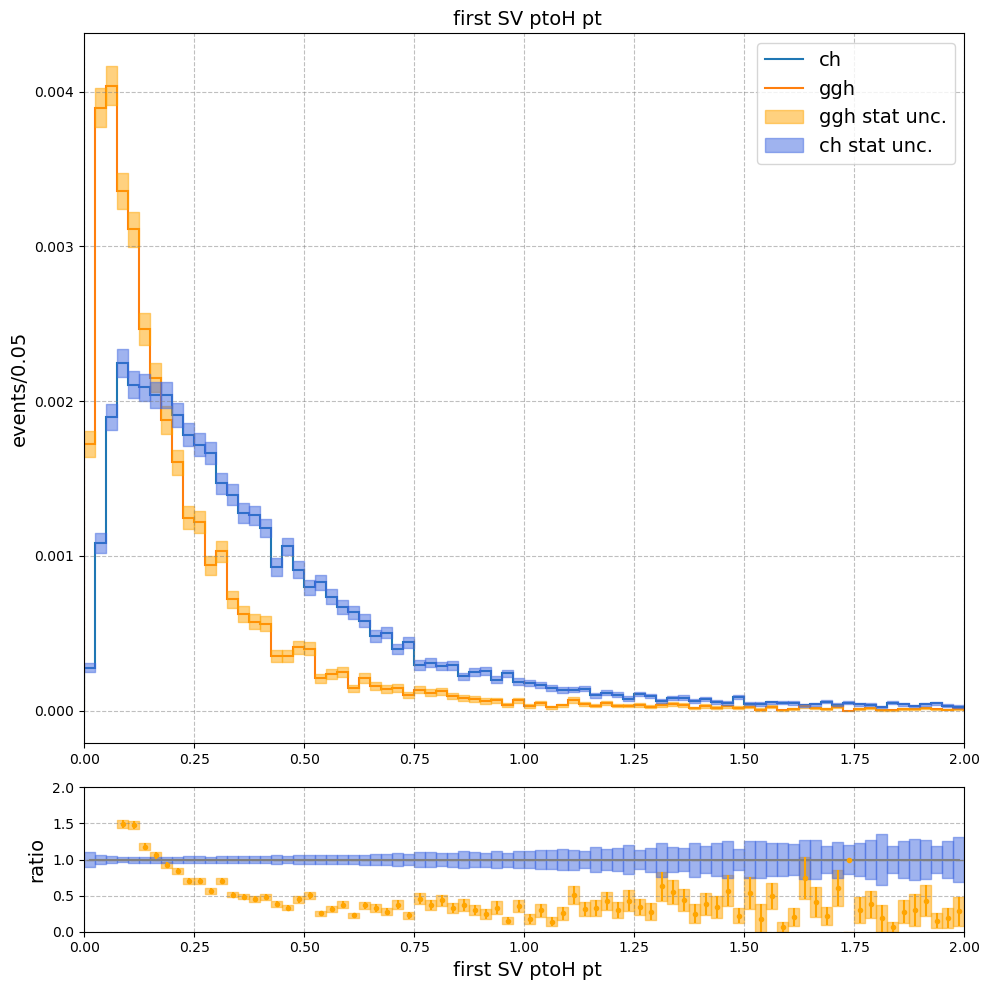

1.0
1.0000000000000004


In [105]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "first_SV_ptoH_pt"
title = ""
for x in var.split("_"):
    title = title + " " + x
min_ = 0
max_ = 2
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="ax")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "ch"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)
full_hist_err = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

norm = {}
norm["tot"] = ak.sum(MC_events.weight)
norm["ggh"] = ak.sum(MC_events.weight[(MC_events.proc_id == 1)])
norm["ch"] = ak.sum(MC_events.weight[(MC_events.proc_id == 5)])
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"], c="ggh")
full_hist.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"], c="ch")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 1)], weight=MC_events.square_weight[(MC_events.proc_id == 1)], c="ggh")
full_hist_err.fill(ax = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.square_weight[(MC_events.proc_id == 5)], c="ch")

h_stack = full_hist.stack("c")
h_stack_err = full_hist_err.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
# h_sig.project("ax").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
for sample in ["ggh", "ch"]:
    mc["bins"][sample], mc["edges"][sample] = full_hist[:,sample].to_numpy()
    half_bin = np.abs((mc["edges"][sample][1] - mc["edges"][sample][0])) / 2
    mc["edges"][sample] = mc["edges"][sample] + half_bin
    mc["errs"][sample] = np.sqrt(full_hist_err[:,sample].to_numpy()[0])/norm[sample]

ydn = {}
yup = {}
#create up and down edges to plot shaded area for each bin
ydn["ggh"] = [mc["bins"]["ggh"][i] - x for i, x in enumerate(mc["errs"]["ggh"])]
ydn["ch"]= [mc["bins"]["ch"][i] - x for i, x in enumerate(mc["errs"]["ch"])]
yup["ggh"] = [mc["bins"]["ggh"][i] + x for i, x in enumerate(mc["errs"]["ggh"])]
yup["ch"]= [mc["bins"]["ch"][i] + x for i, x in enumerate(mc["errs"]["ch"])]

# plot shaded area for MC errors
colours = ["orange", "royalblue"]
for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"][sample][:-1]):
        if i == 0:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label=f"{sample} stat unc.") # we want just one entry in the legend
        else:
            ax0.fill_between([x - half_bin, x + half_bin], [ydn[sample][i], ydn[sample][i]], [yup[sample][i], yup[sample][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="")
"""
h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var], weight = data_events.weight)

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
"""
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title(title, fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
# ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["ggh"] != 0,
    mc["bins"]["ggh"] / mc["bins"]["ch"],
    ak.ones_like(mc["bins"]["ggh"])
)
ax1.plot(mc["edges"]["ggh"][:-1], ak.ones_like(mc["bins"]["ggh"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["ggh"][:-1], ratio, yerr = abs(mc["errs"]["ggh"]/mc["bins"]["ch"]), color=colours[0], marker=".", linestyle="", label="ggh")

for j, sample in enumerate(["ggh", "ch"]):
    for i, x in enumerate(mc["edges"]["ggh"][:-1]):
        ax1.fill_between([x - half_bin, x + half_bin], [ydn[sample][i]/mc["bins"]["ch"][i], ydn[sample][i]/mc["bins"]["ch"][i]], [yup[sample][i]/mc["bins"]["ch"][i], yup[sample][i]/mc["bins"]["ch"][i]], facecolor=colours[j], alpha=0.5, edgecolor=colours[j], label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])

ax1.set_xlabel(title, fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
#if SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

print(ak.sum(MC_events.weight[(MC_events.proc_id == 1)]/norm["ggh"]))
print(ak.sum(MC_events.weight[(MC_events.proc_id == 5)]/norm["ch"]))